Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause

In [ ]:
%load_ext autoreload
%autoreload 2

In [47]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from calibrated_explanations import CalibratedExplainer, VennAbers, __version__
from lime.lime_tabular import LimeTabularExplainer

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.3.1


In [ ]:

dataSet = 'glass'
delimiter = ','
num_to_test = 24
print(dataSet)

fileName = '../data/Multiclass/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Type'

df = df.dropna()
categorical_features = []
categorical_labels = {}
for c, col in enumerate(df.columns):
    if df[col].dtype == object:
        df[col] = df[col].str.replace("'", "")
        df[col] = df[col].str.replace('"', '')
        if col != target:
            categorical_features.append(c)
            categorical_labels[c] = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        else:
            target_labels = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        mapping = dict(zip(np.unique(df[col]), range(len(np.unique(df[col])))))
        if len(mapping) > 5:
            counts = df[col].value_counts().sort_values(ascending=False)
            id = 0
            for key, count in counts.items():
                if count > 5:
                    id += 1
                    continue
                mapping[key] = id
        df[col] = df[col].map(mapping)
print(target_labels)

In [ ]:
df.head()

In [ ]:
X, y = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]
# sort targets to make sure equal presence of both classes in test set (see definition of test_index after outer loop below)
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_idx = []
idx = list(range(no_of_instances))
for i in range(no_of_classes):
    test_idx.append(np.where(y == i)[0][0:int(num_to_test/no_of_classes)])
test_index = np.array(test_idx).flatten()
# Select num_to_test/2 from top and num_to_test/2 from bottom of list of instances
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)
print(testY)
print(categorical_features)

In [ ]:
model = RandomForestClassifier(n_estimators=100)
model_name = 'RF' 
model.fit(trainX,trainY)  

In [35]:
va = VennAbers(model.predict_proba(calX), calY, model)
va_proba, low, high, predicted_classes = va.predict_proba(testX, output_interval=True)
print(*zip([low[i,c] for i,c in enumerate(predicted_classes)], [va_proba[i,c] for i,c in enumerate(predicted_classes)], [high[i,c] for i,c in enumerate(predicted_classes)], testY, predicted_classes),sep='\n')  

(0.9090909361839294, 0.9166666894323302, 1.0, 0, 0)
(0.8571428656578064, 0.875000006519258, 1.0, 0, 0)
(0.8999999761581421, 0.9090908893868948, 1.0, 0, 0)
(0.75, 0.8, 1.0, 0, 0)
(0.5, 0.5555555555555556, 0.625, 1, 1)
(0.3333333432674408, 0.42857143222069255, 0.5, 1, 1)
(0.3333333432674408, 0.42857143222069255, 0.5, 1, 1)
(0.5454545617103577, 0.6226415178367531, 0.75, 1, 1)
(0.6666666865348816, 0.7500000111758711, 1.0, 2, 3)
(0.6666666865348816, 0.7500000111758711, 1.0, 2, 2)
(0.6666666865348816, 0.7500000111758711, 1.0, 2, 2)
(0.0, 0.5, 1.0, 2, 2)
(0.875, 0.8888888888888888, 1.0, 3, 3)
(0.8333333134651184, 0.8571428425458015, 1.0, 3, 3)
(0.8333333134651184, 0.8571428425458015, 1.0, 3, 3)
(0.8333333134651184, 0.8571428425458015, 1.0, 3, 3)
(0.5, 0.6666666666666666, 1.0, 4, 4)
(0.5, 0.6666666666666666, 1.0, 4, 2)
(0.5, 0.6666666666666666, 1.0, 4, 4)
(0.6666666865348816, 0.7500000111758711, 1.0, 4, 4)
(0.4000000059604645, 0.4545454570084564, 0.5, 5, 1)
(0.6363636255264282, 0.6874999967985

In [48]:
print(target_labels,end='\n\nConfusions matrix on test set:\n')

cm = confusion_matrix(testY, predicted_classes)
print(cm, end='\n\nConfusions matrix on calibration set:\n')

cal_predicted_classes = np.zeros(len(calY))
for i in range(len(calY)):
    va = VennAbers(model.predict_proba(np.concatenate((calX[:i], calX[i+1:]), axis=0)), np.concatenate((calY[:i], calY[i+1:])), model)
    _, _, _, predict = va.predict_proba([calX[i]], output_interval=True)
    cal_predicted_classes[i] = predict[0]
cm = confusion_matrix(calY, cal_predicted_classes)

print(cm)

for i in range(no_of_classes):
    print()
    print(f"Class {i} {target_labels[i]}")
    print(f"Precision: {cm[i,i]/np.sum(cm[:,i])}")
    print(f"Recall: {cm[i,i]/np.sum(cm[i,:])}")
    print(f"F1: {2*cm[i,i]/(np.sum(cm[:,i]) + np.sum(cm[i,:]))}")



{0: 'build wind float', 1: 'build wind non-float', 2: 'containers', 3: 'headlamps', 4: 'tableware', 5: 'vehic wind float'}

[[4 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 3 1 0 0]
 [0 0 0 4 0 0]
 [0 0 1 0 3 0]
 [2 1 0 0 0 1]]

[[18  4  0  0  0  0]
 [ 4 18  0  1  1  0]
 [ 0  1  2  0  0  0]
 [ 1  0  0  7  0  0]
 [ 0  0  0  0  2  0]
 [ 2  2  0  0  0  0]]

Class 0 build wind float
Precision: 0.72
Recall: 0.8181818181818182
F1: 0.7659574468085106

Class 1 build wind non-float
Precision: 0.72
Recall: 0.75
F1: 0.7346938775510204

Class 2 containers
Precision: 1.0
Recall: 0.6666666666666666
F1: 0.8

Class 3 headlamps
Precision: 0.875
Recall: 0.875
F1: 0.875

Class 4 tableware
Precision: 0.6666666666666666
Recall: 1.0
F1: 0.8

Class 5 vehic wind float
Precision: nan
Recall: 0.0
F1: 0.0


c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


In [ ]:
ce = CalibratedExplainer(model, calX, calY, \
                    feature_names=df.columns, \
                    categorical_features=categorical_features, \
                    class_labels=target_labels)
display(ce)

In [ ]:
factual_explanations = ce.explain_factual(testX)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:954: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5+2))


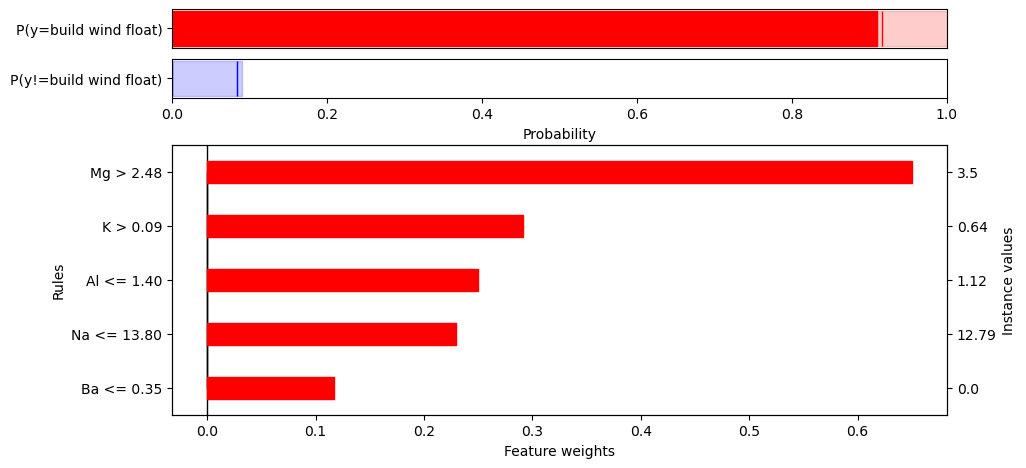

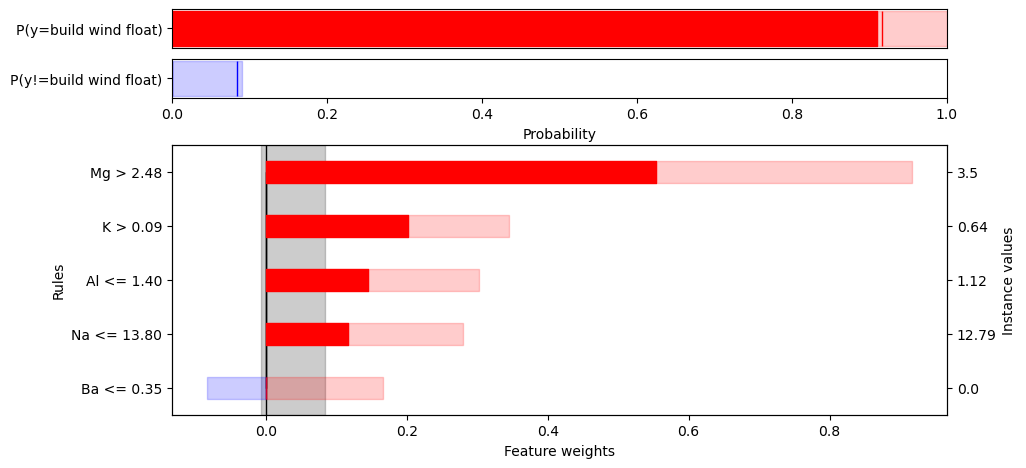

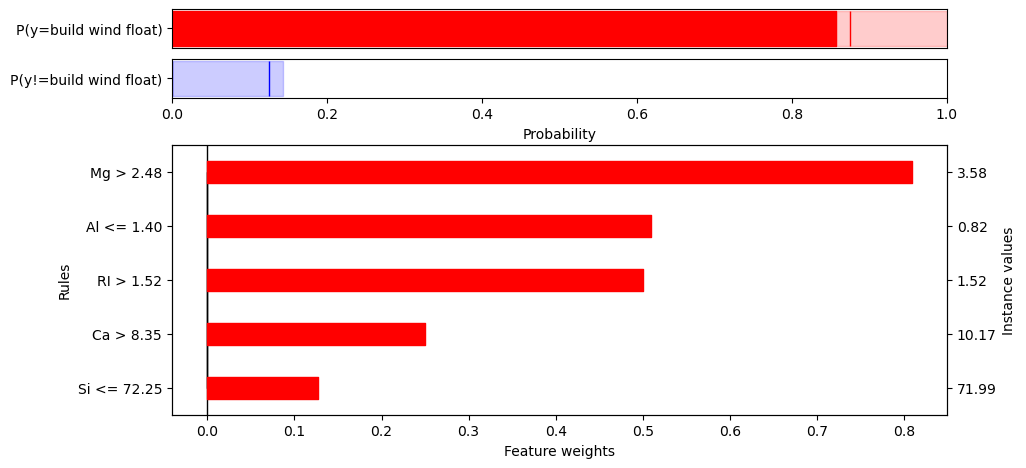

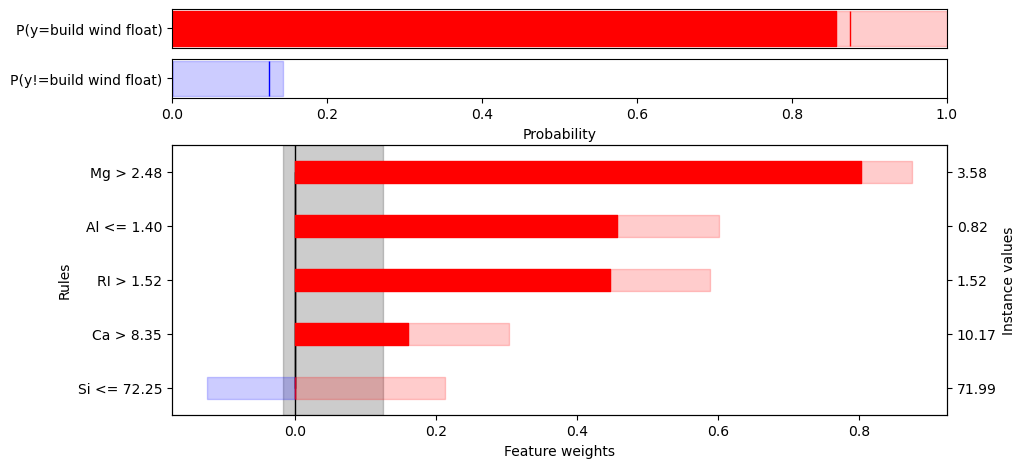

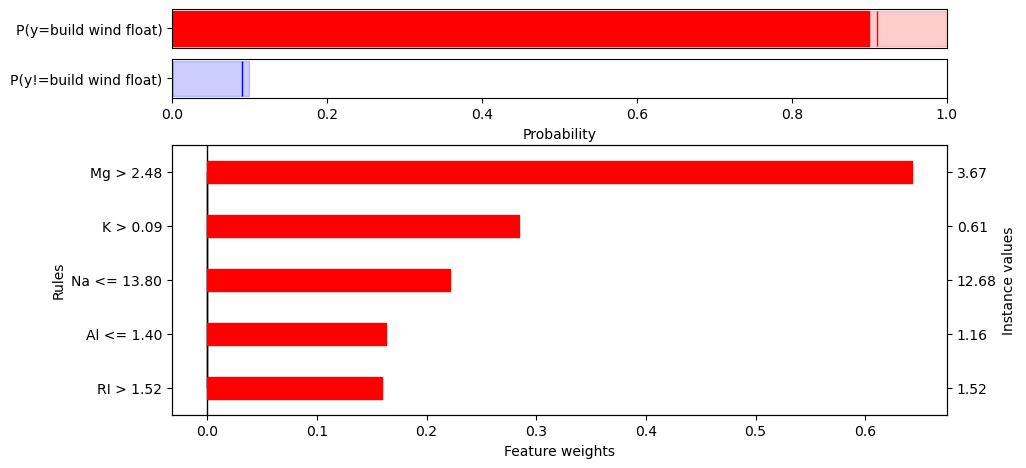

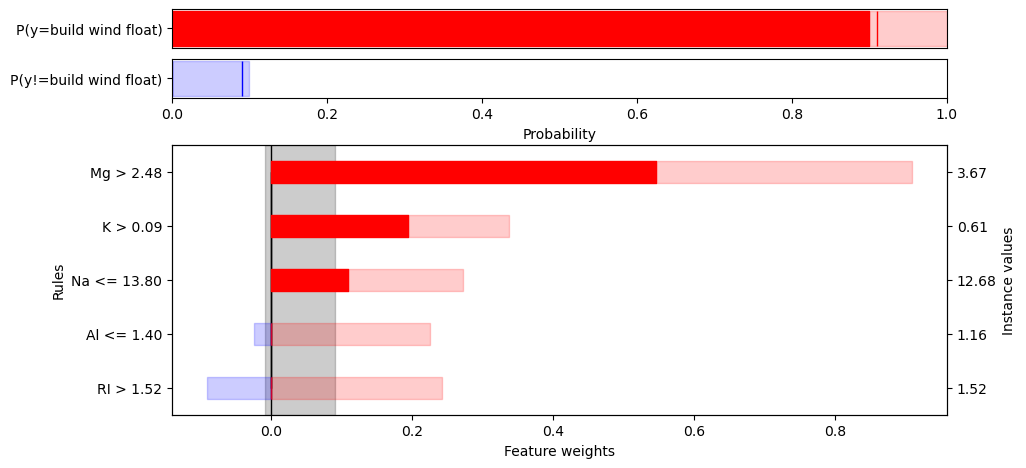

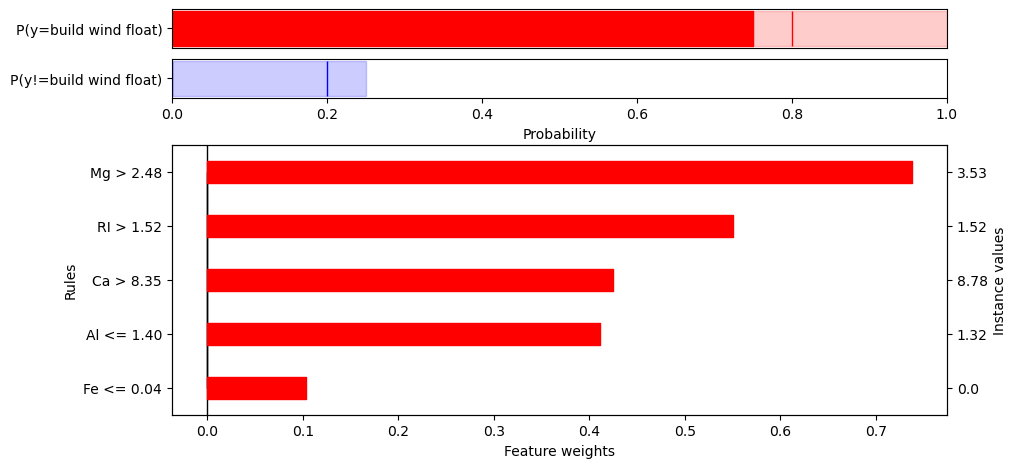

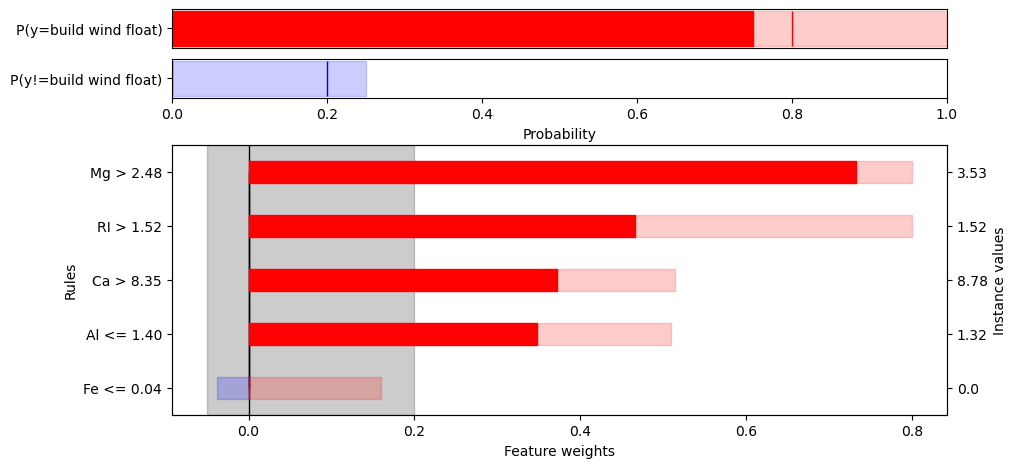

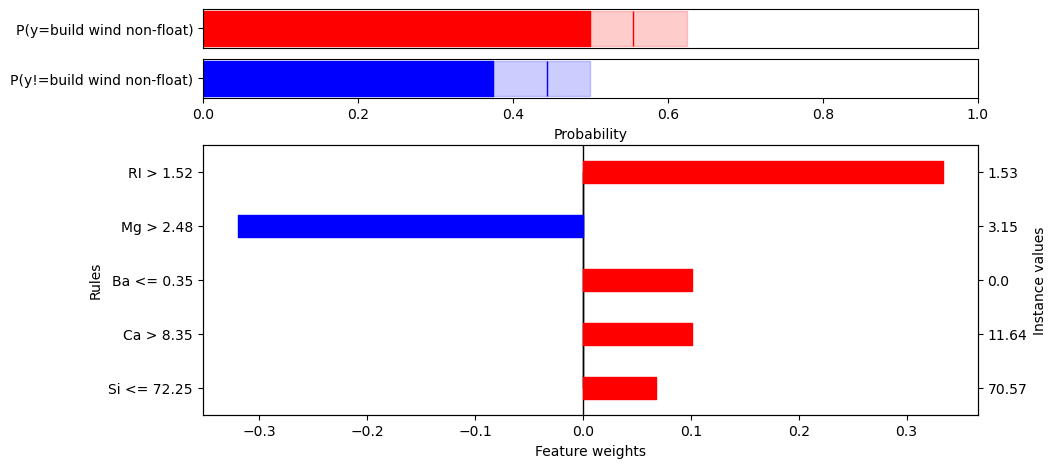

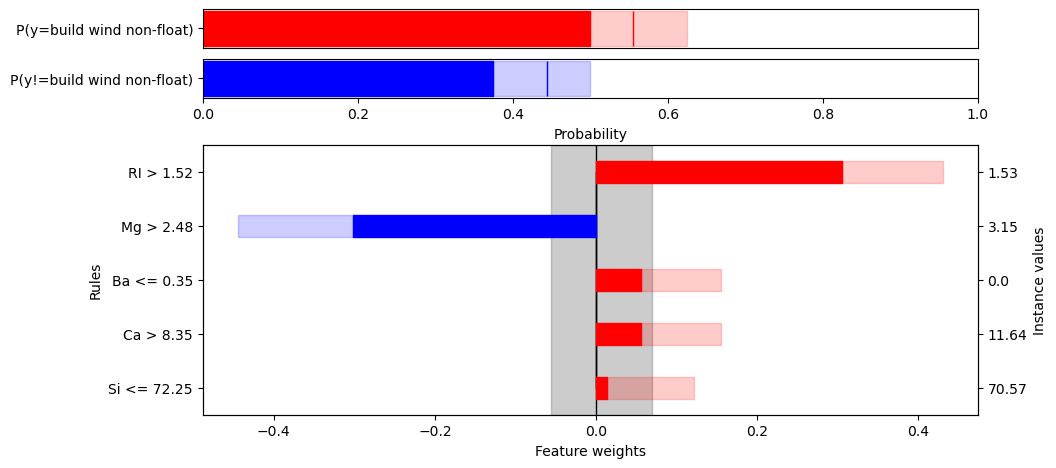

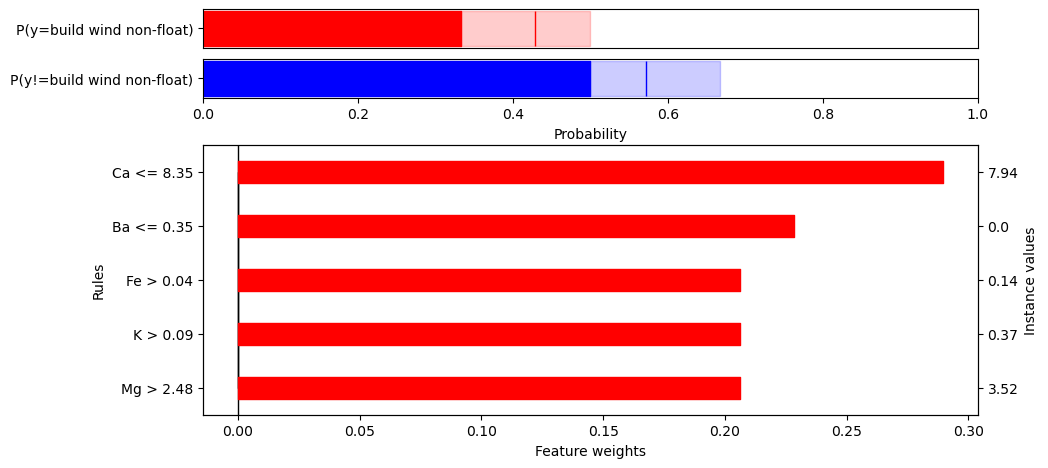

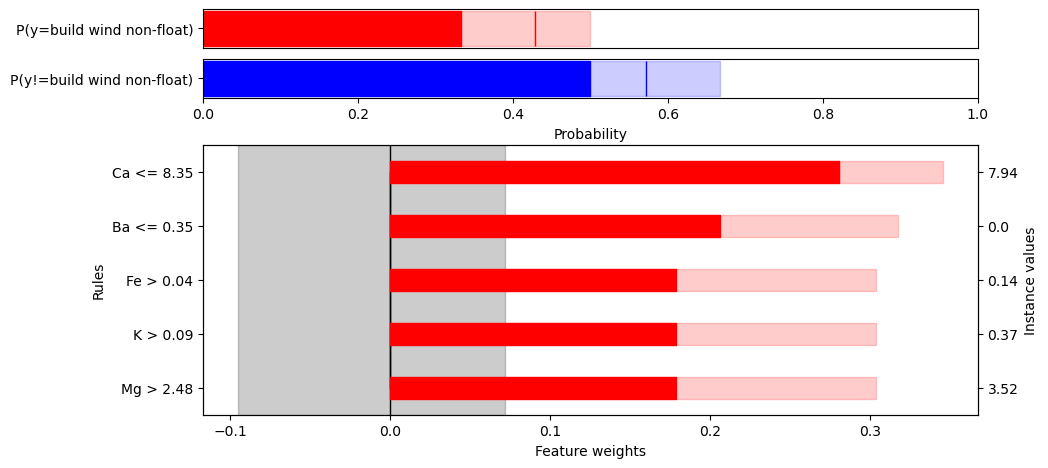

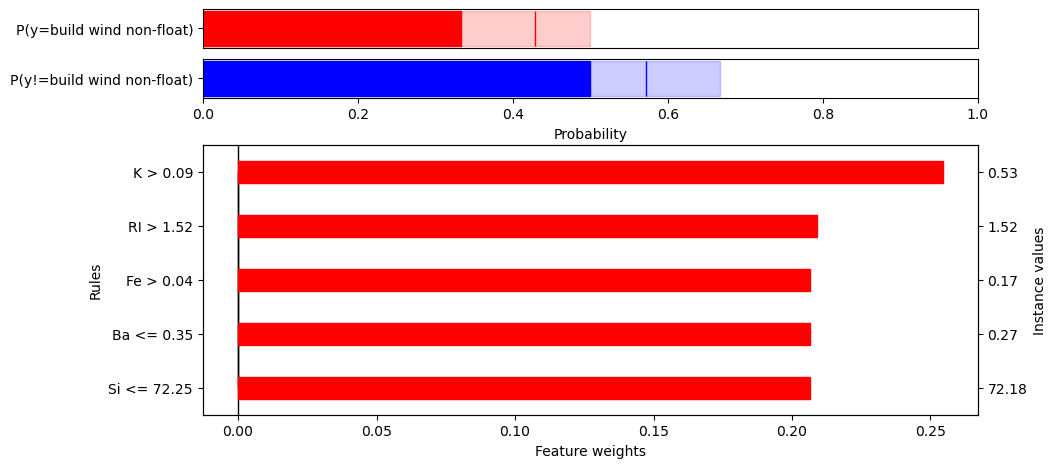

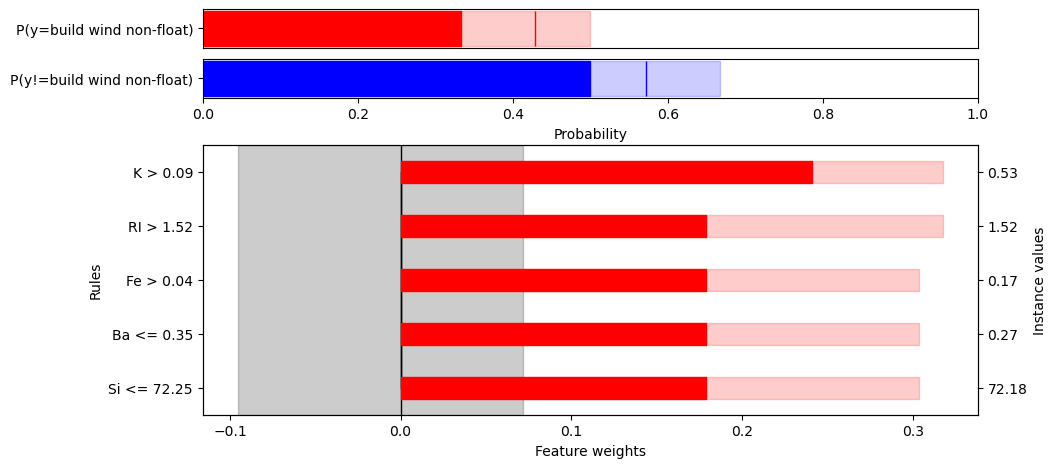

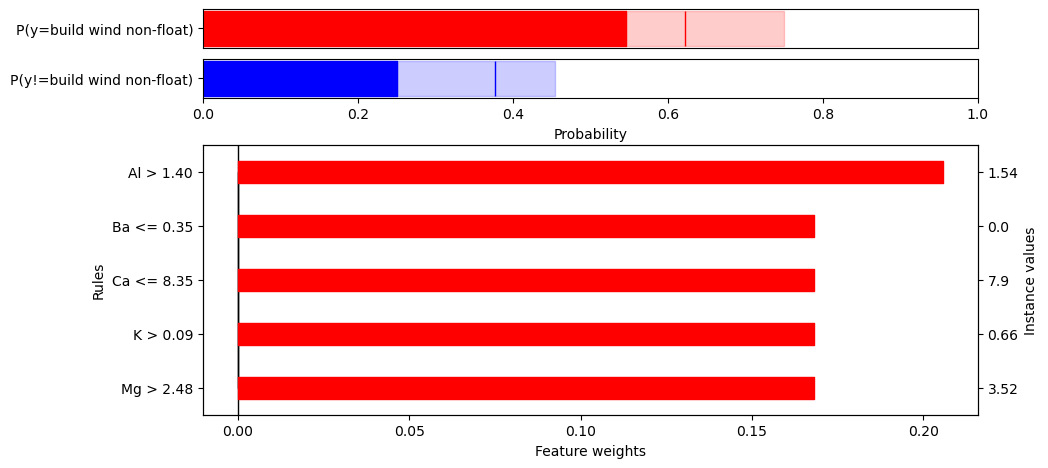

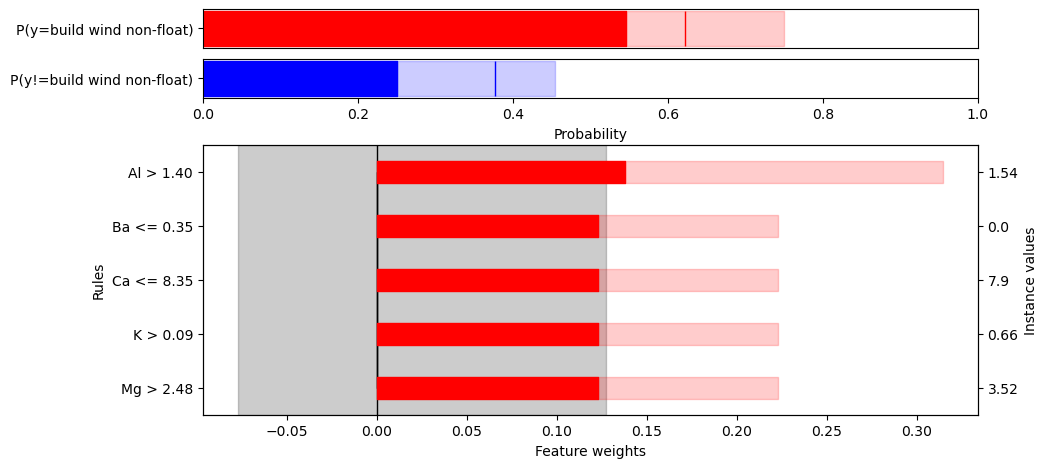

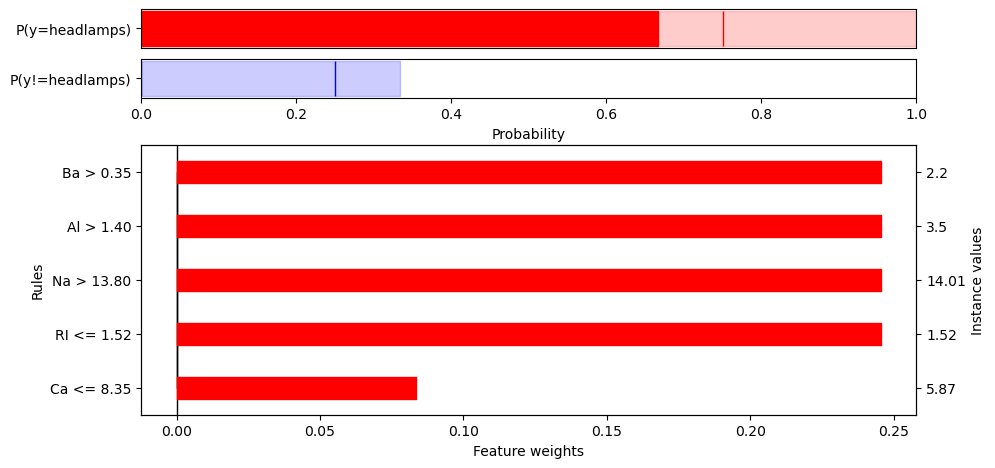

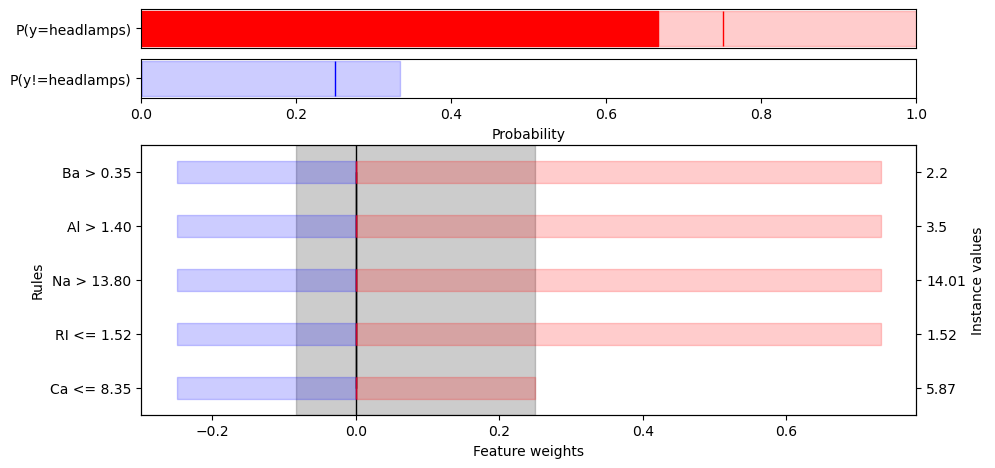

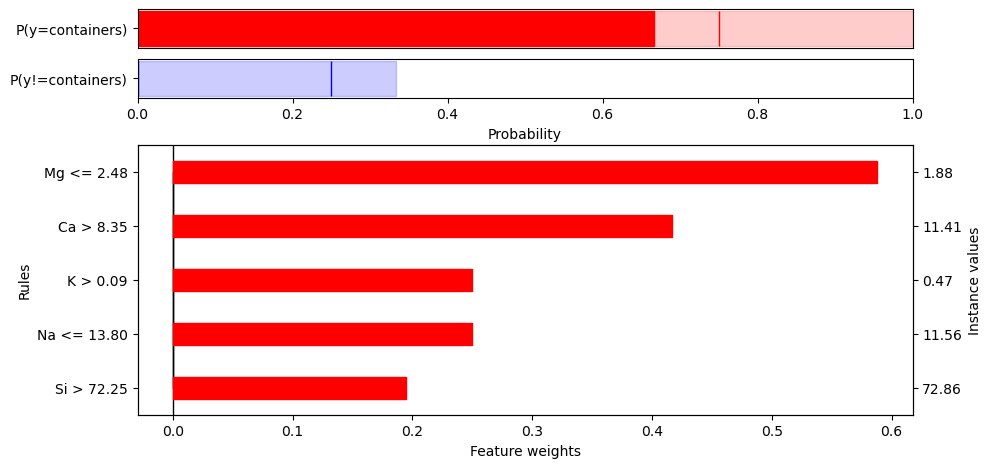

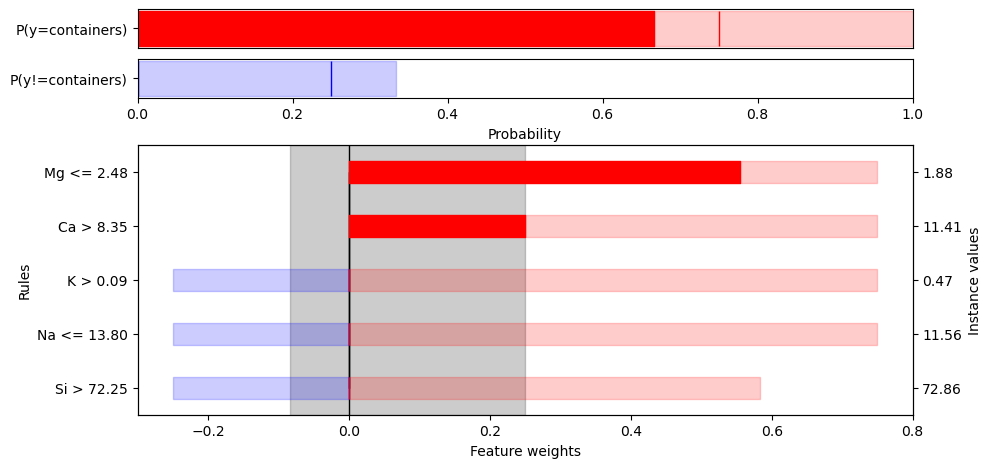

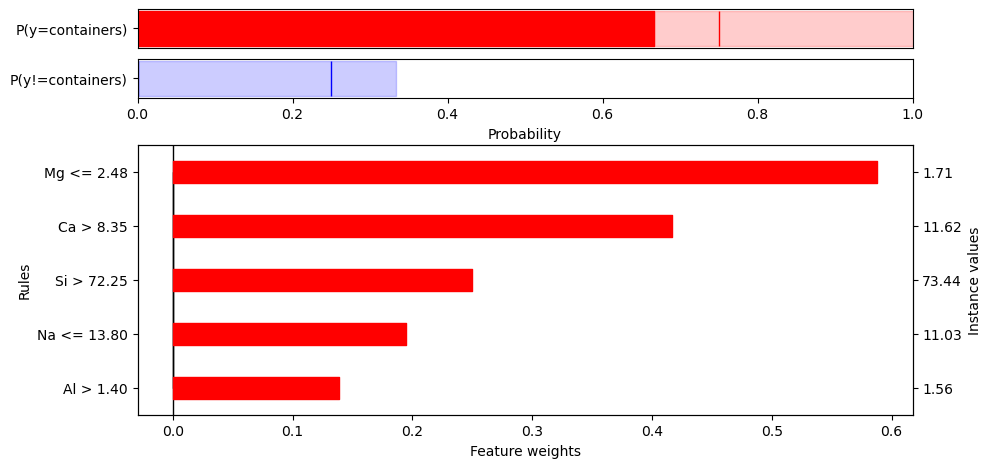

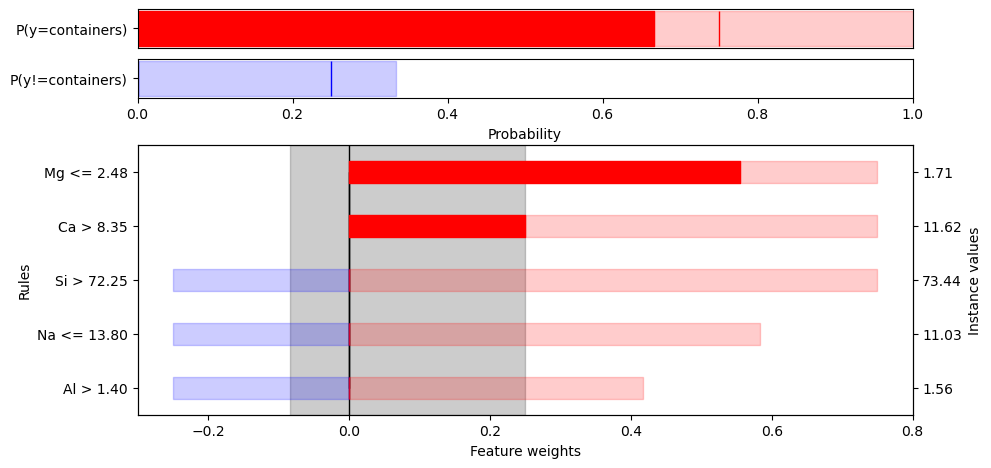

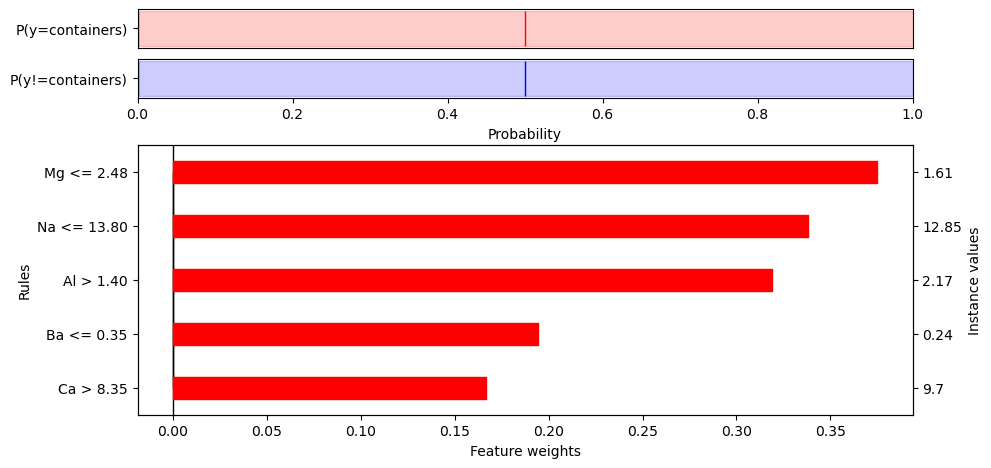

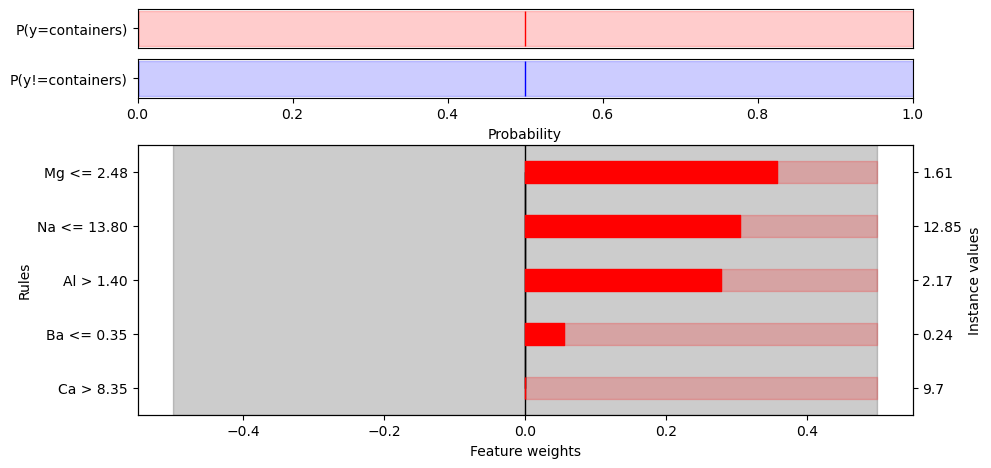

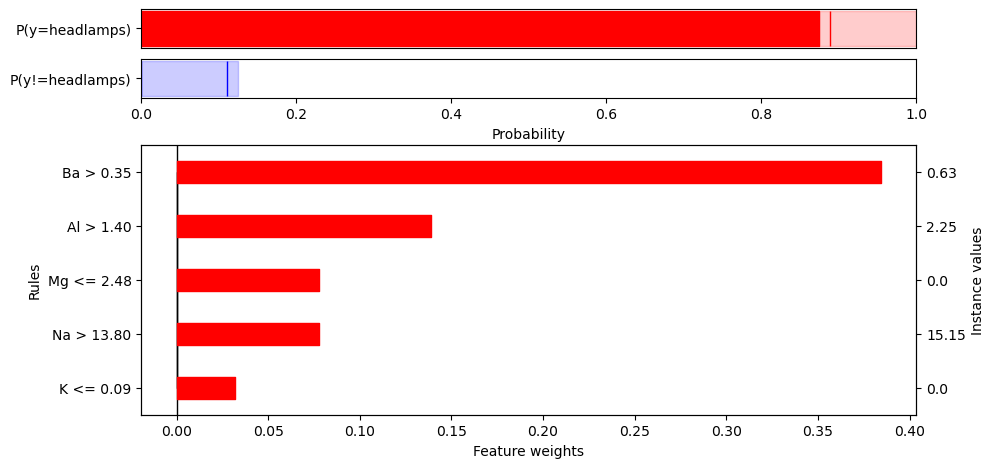

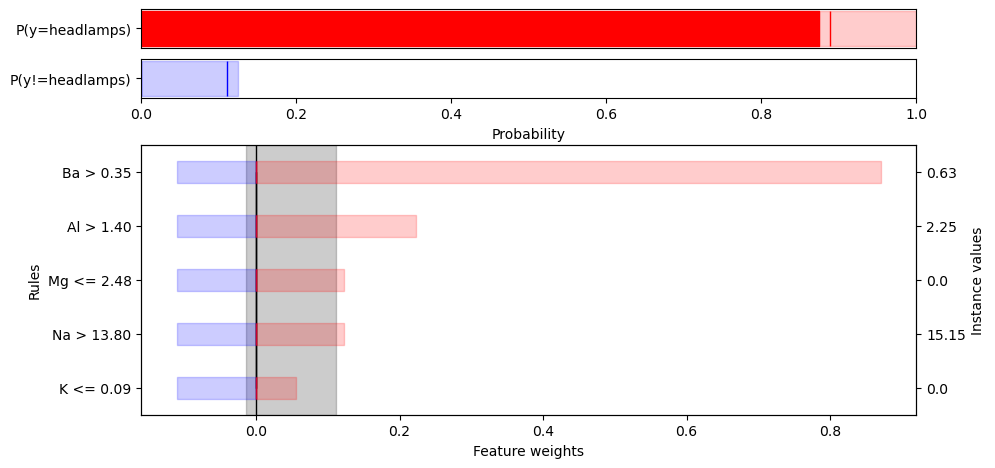

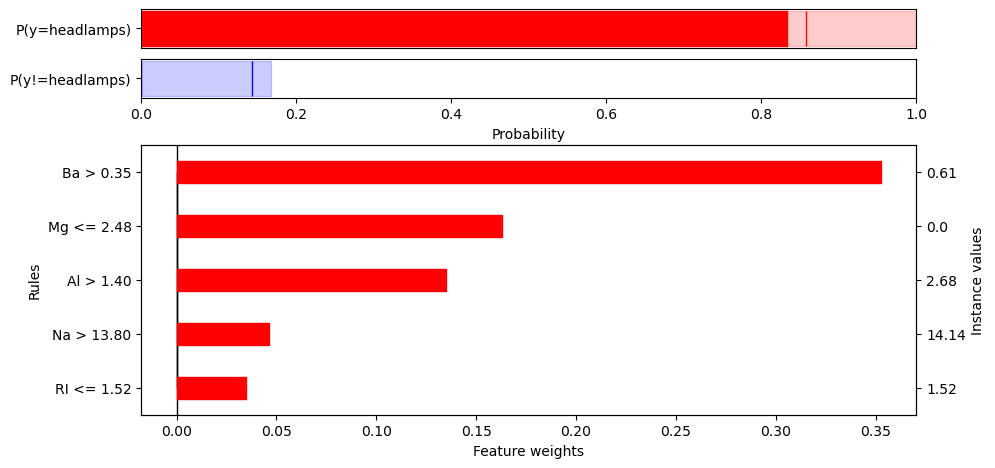

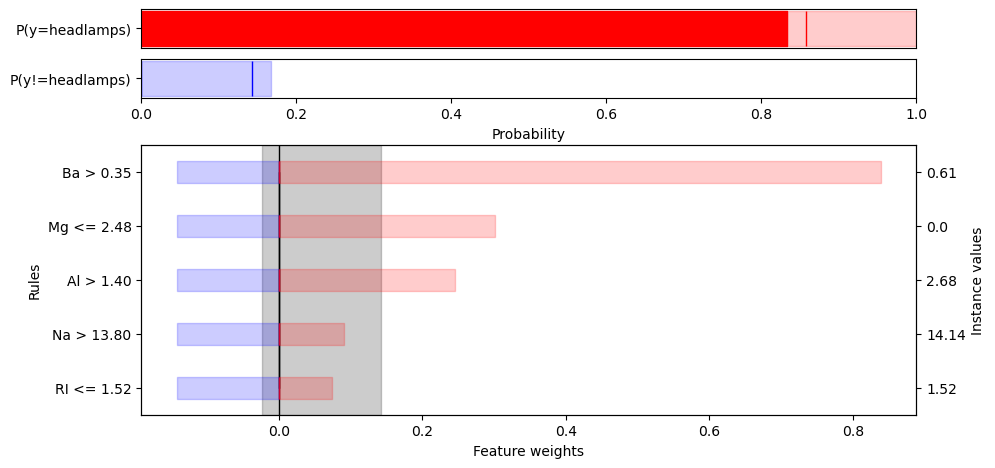

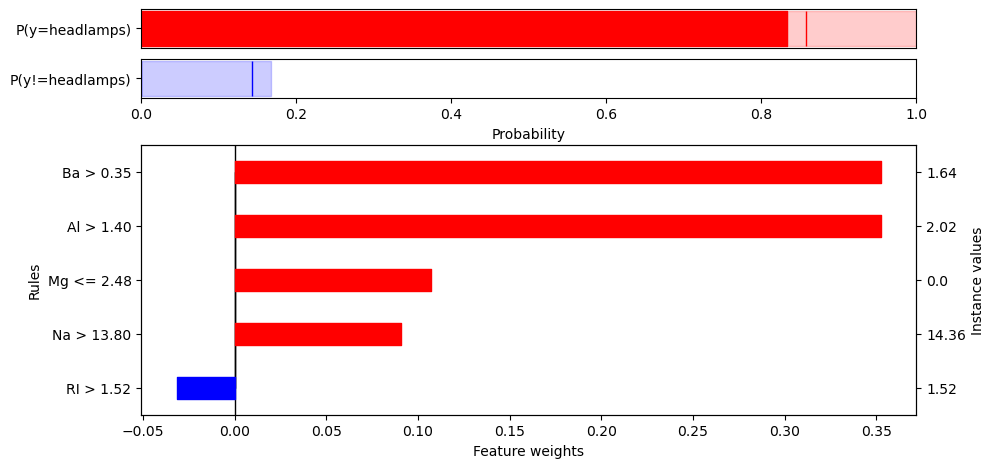

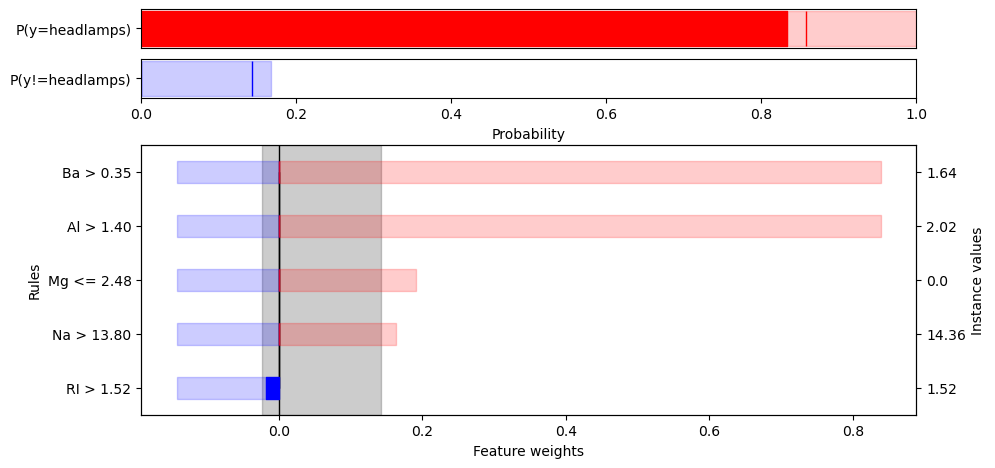

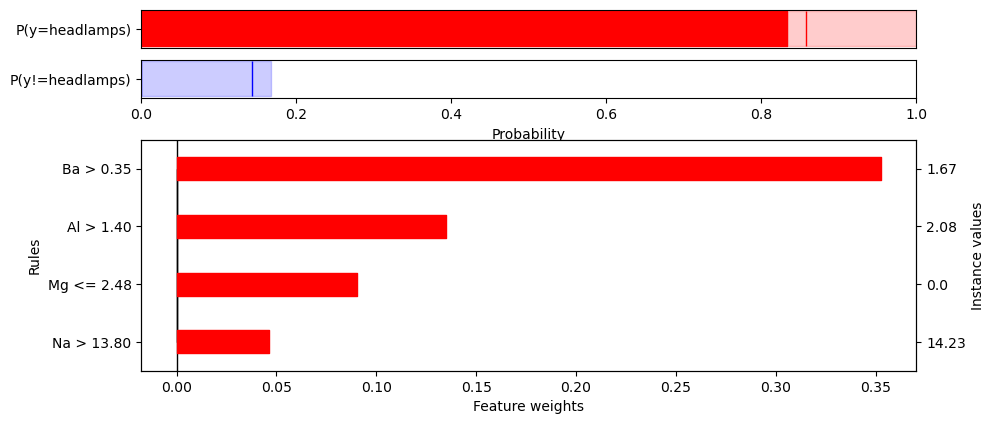

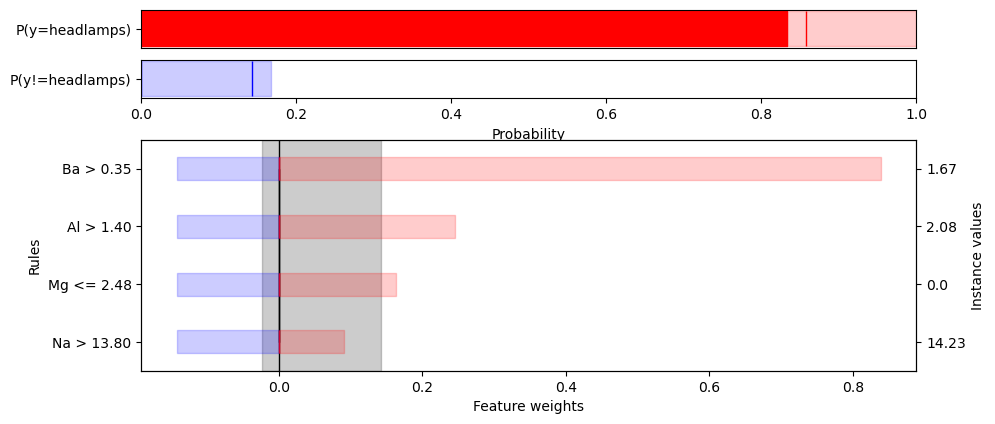

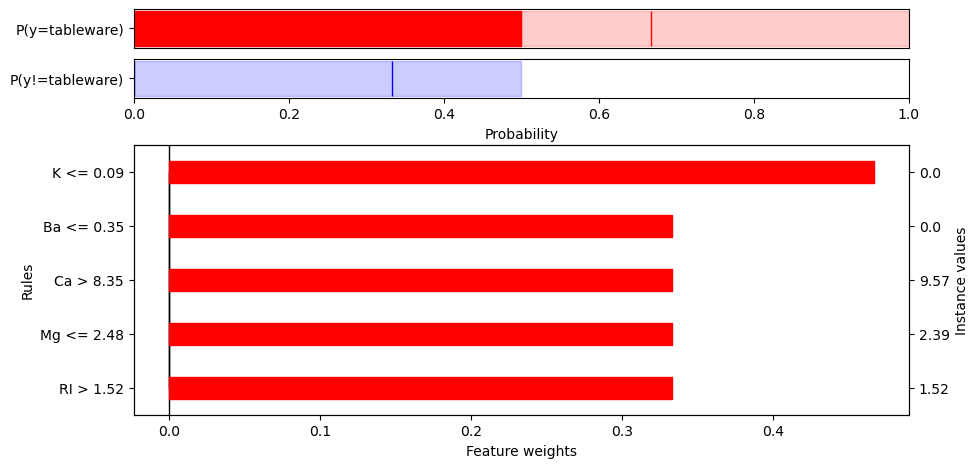

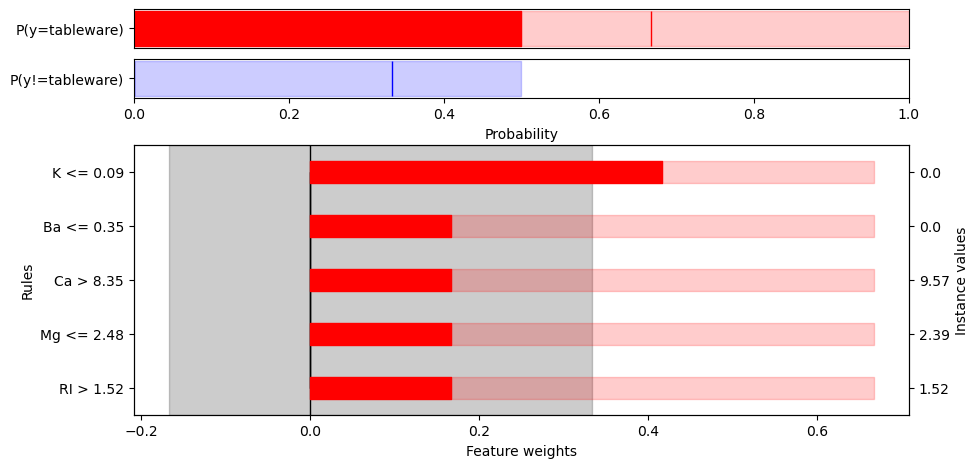

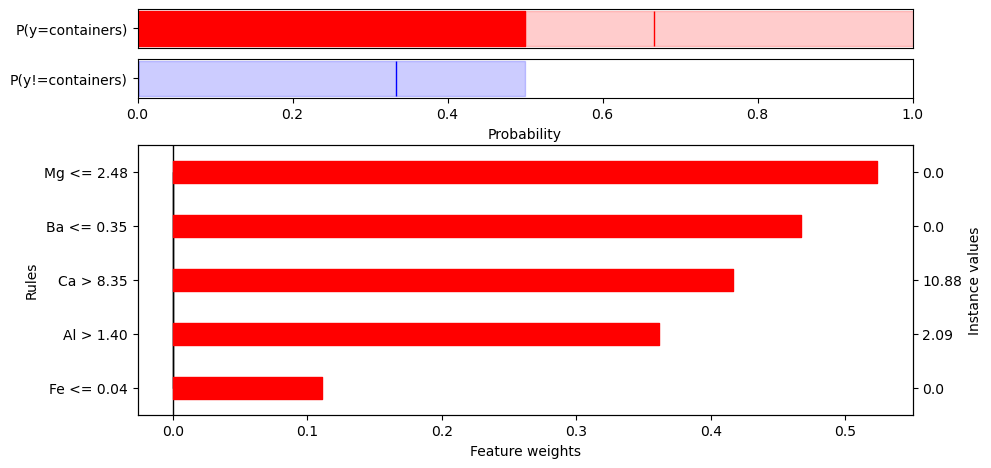

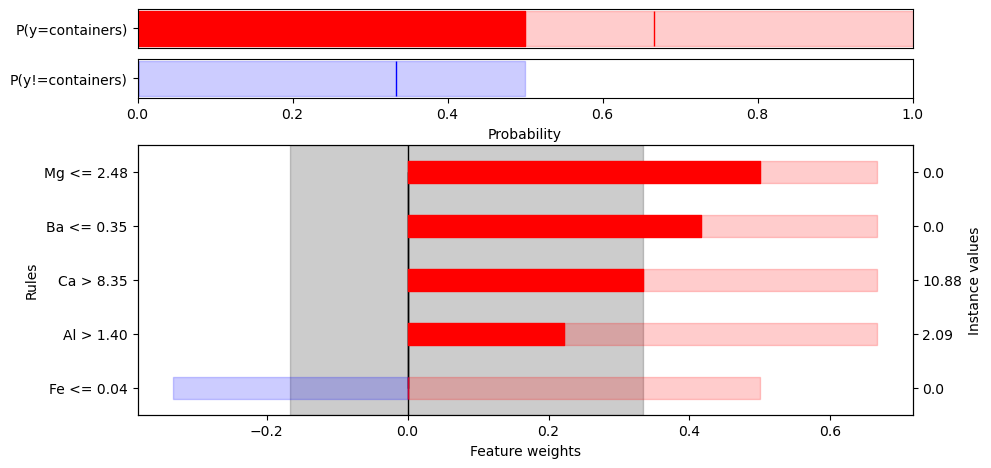

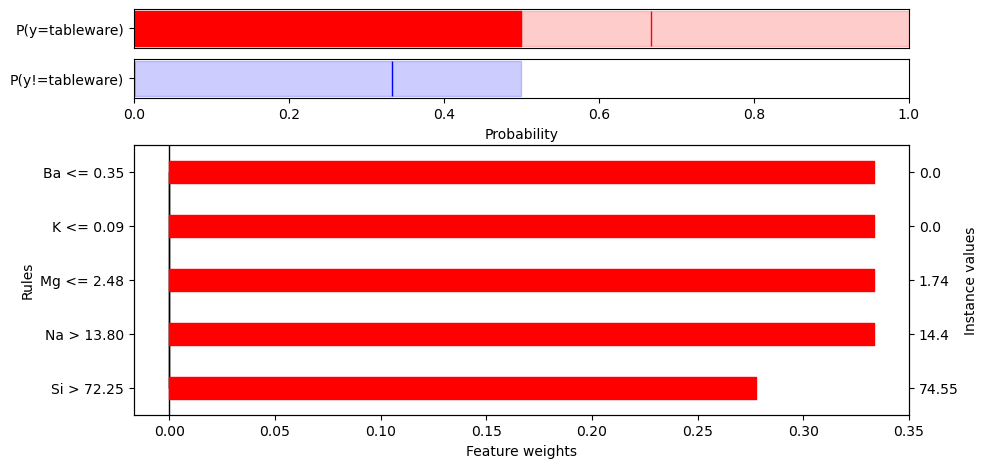

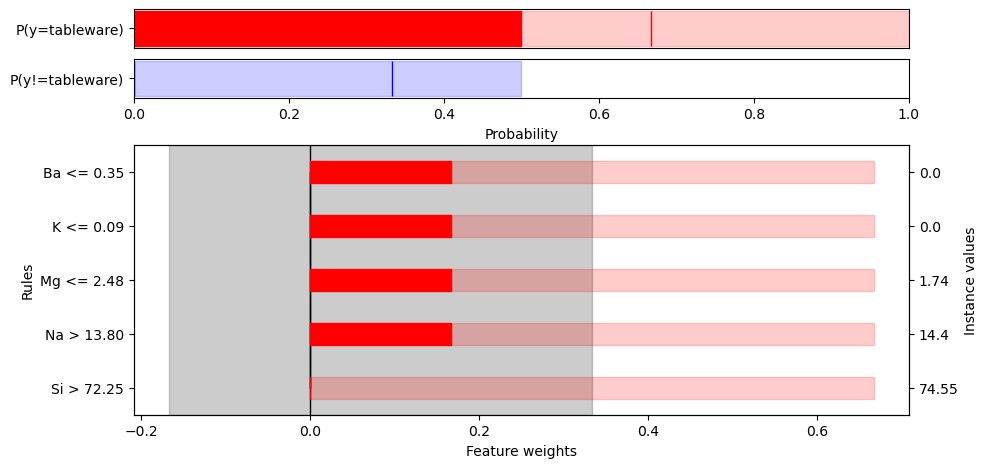

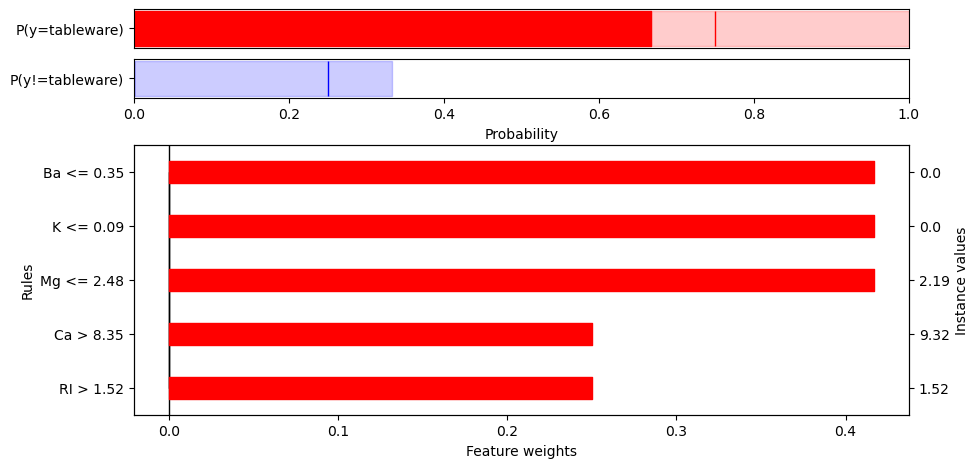

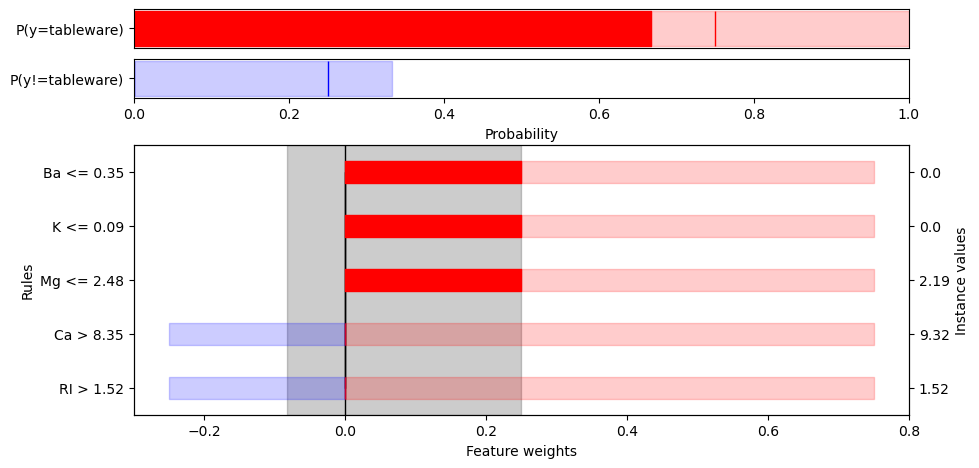

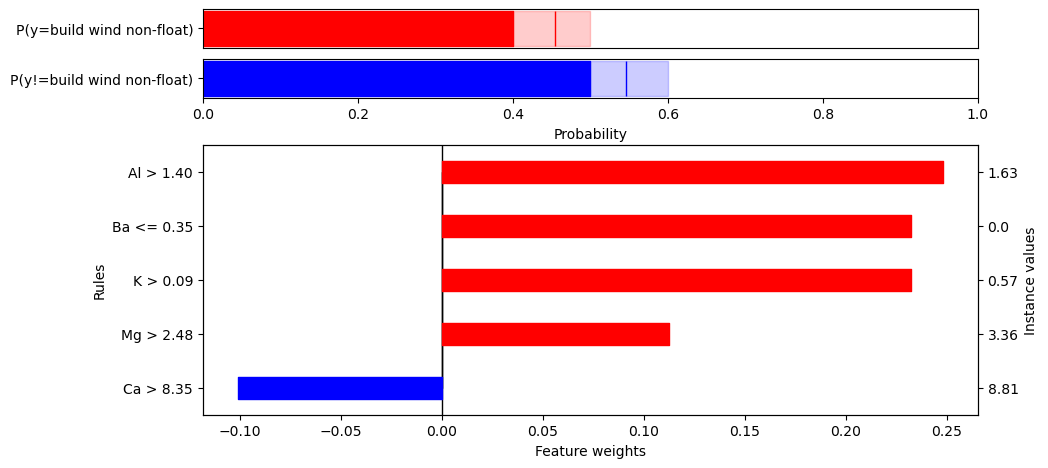

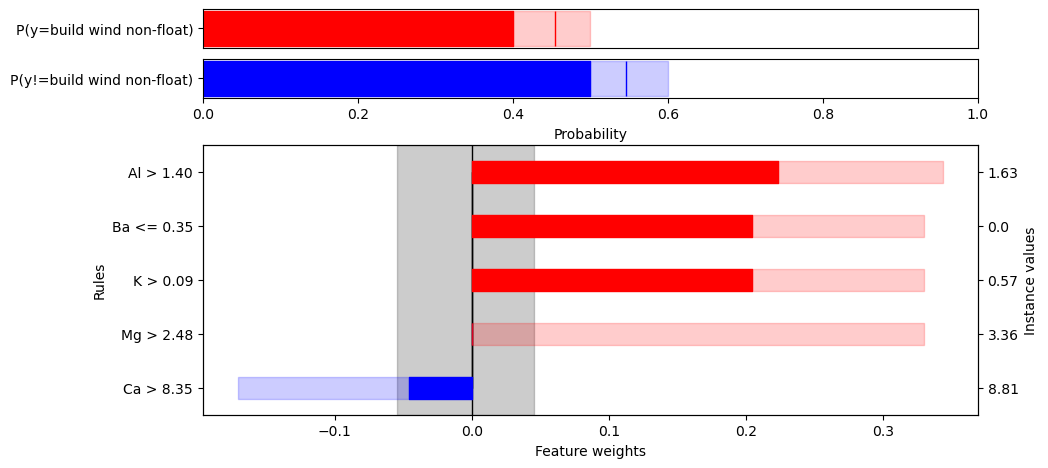

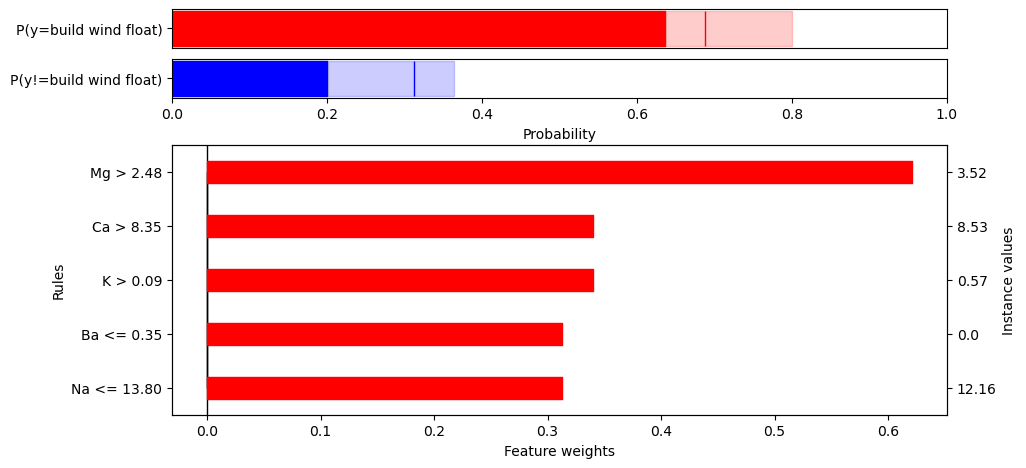

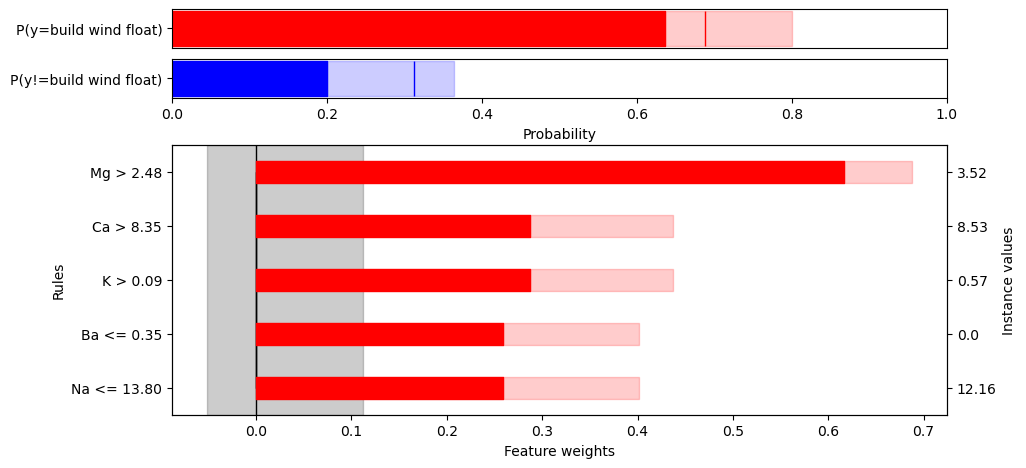

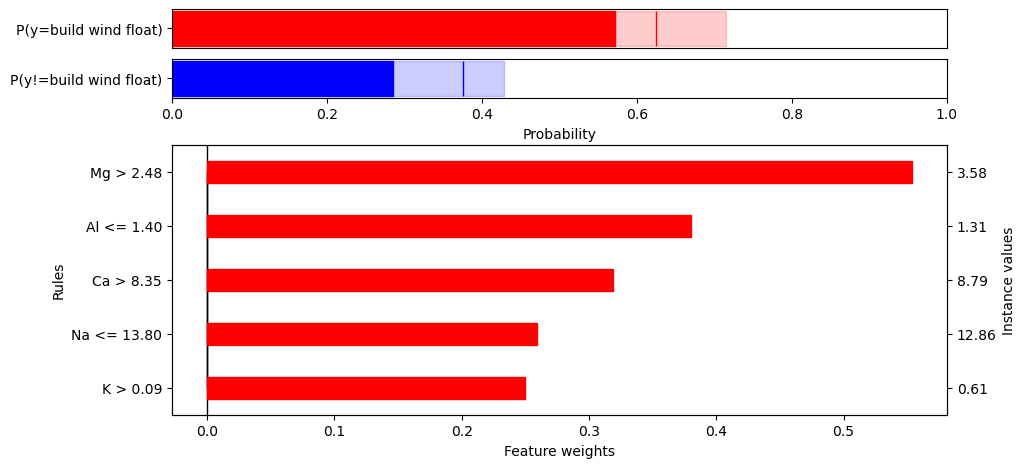

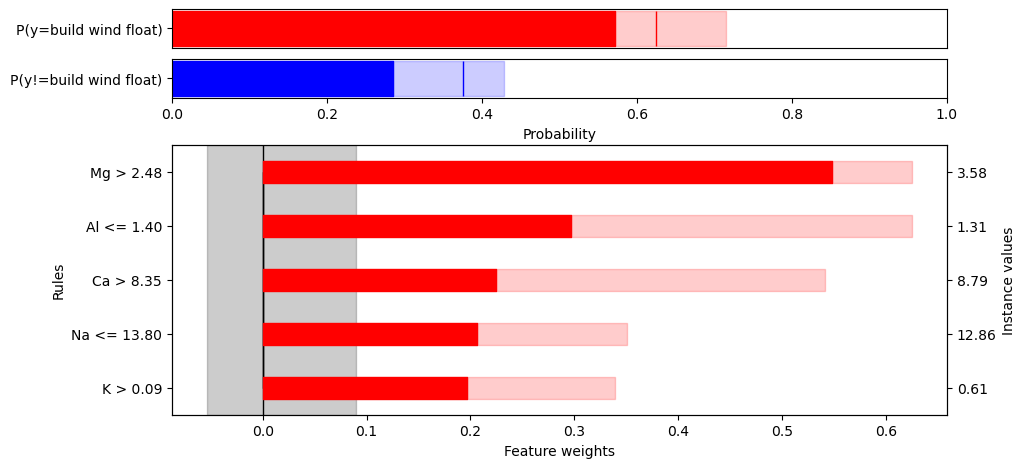

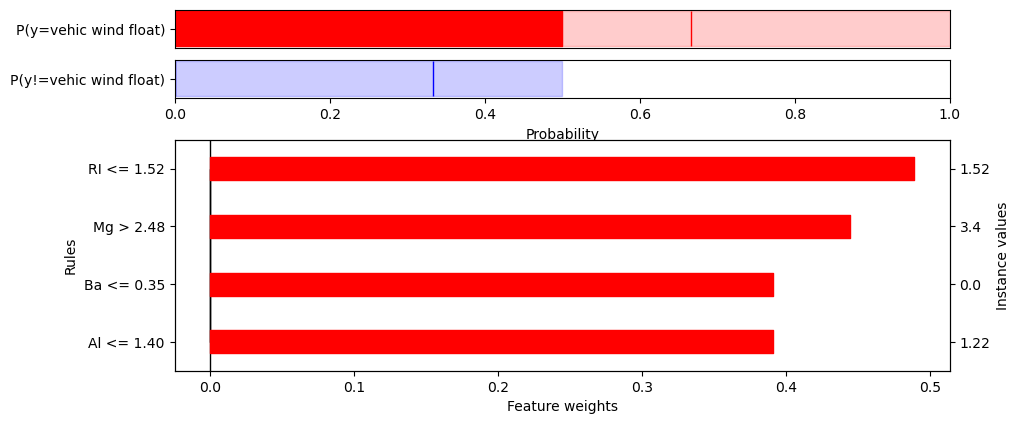

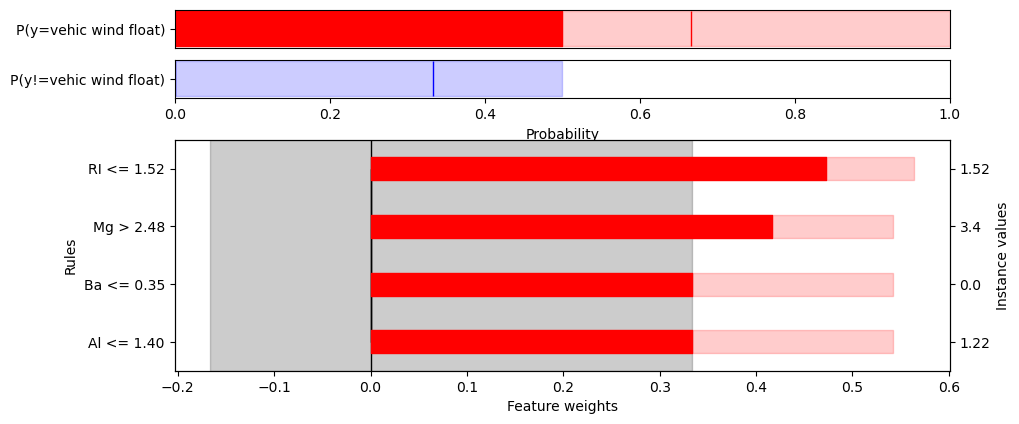

In [30]:
for i in range(num_to_test):
    explanation = factual_explanations.get_explanation(i)
    explanation.plot_explanation(n_features_to_show=5, filename=f'{dataSet}_{i}_c{testY[i]}_p{predicted_classes[i]}_simple_factual.png')
    explanation.plot_explanation(uncertainty=True, n_features_to_show=5, filename=f'{dataSet}_{i}_c{testY[i]}_p{predicted_classes[i]}_simple_factual_uncertainty.png')

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:954: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5+2))


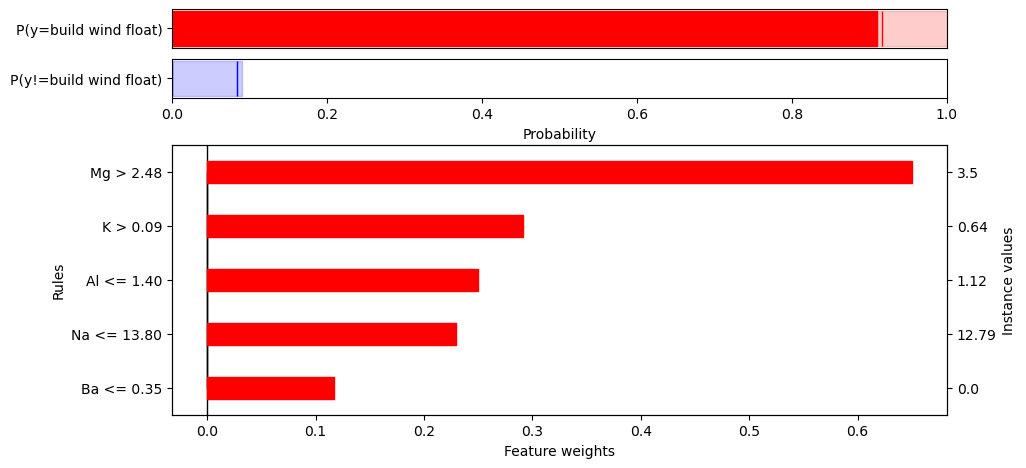

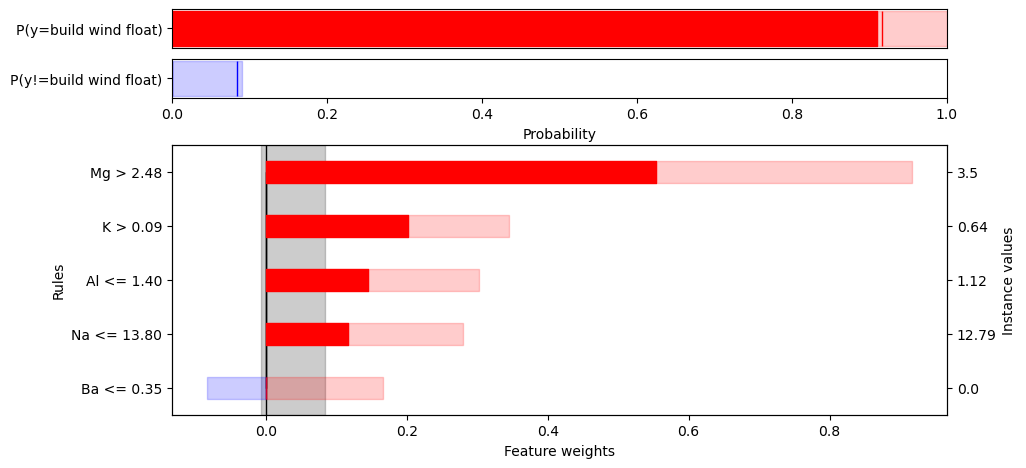

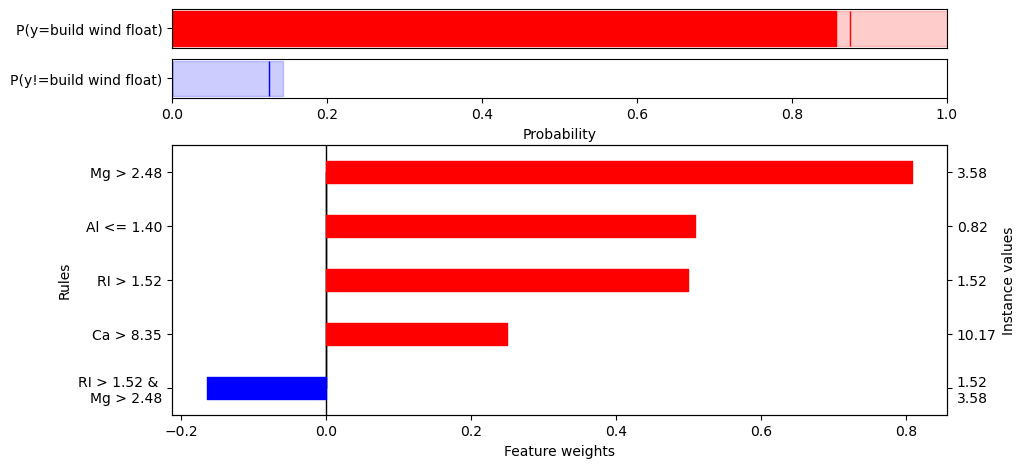

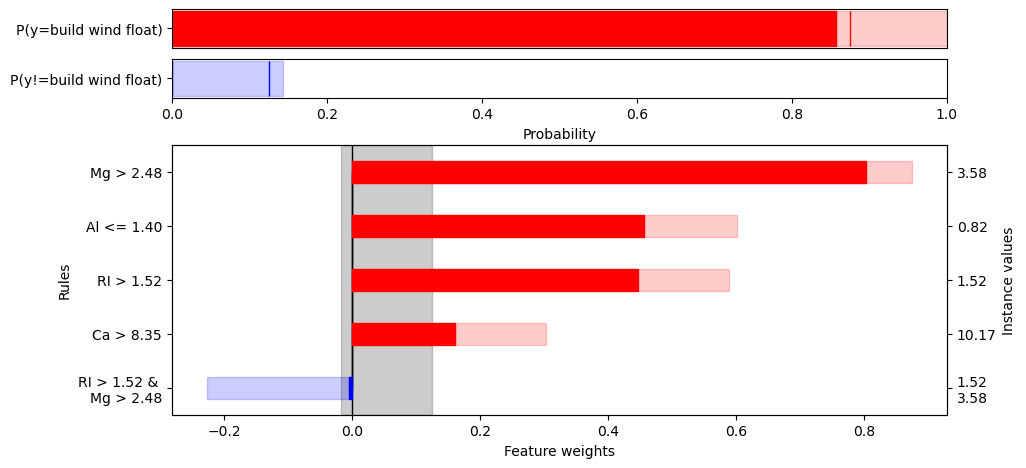

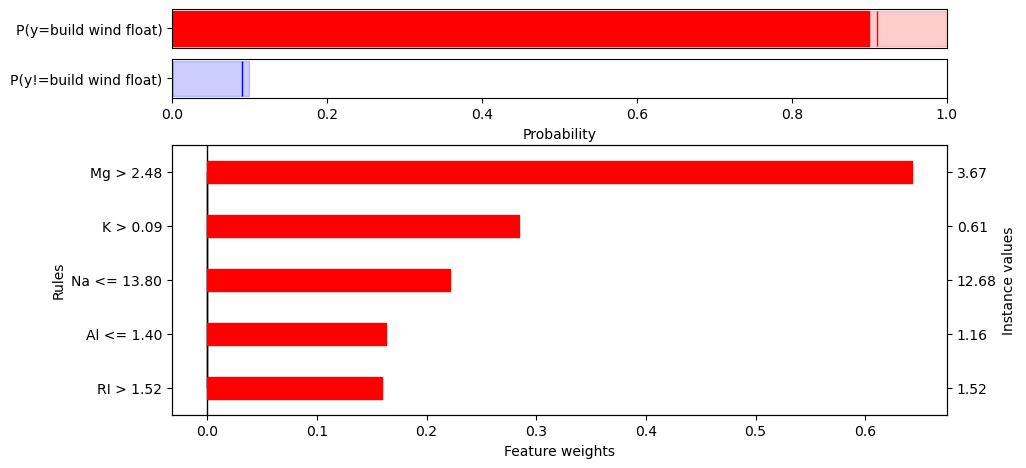

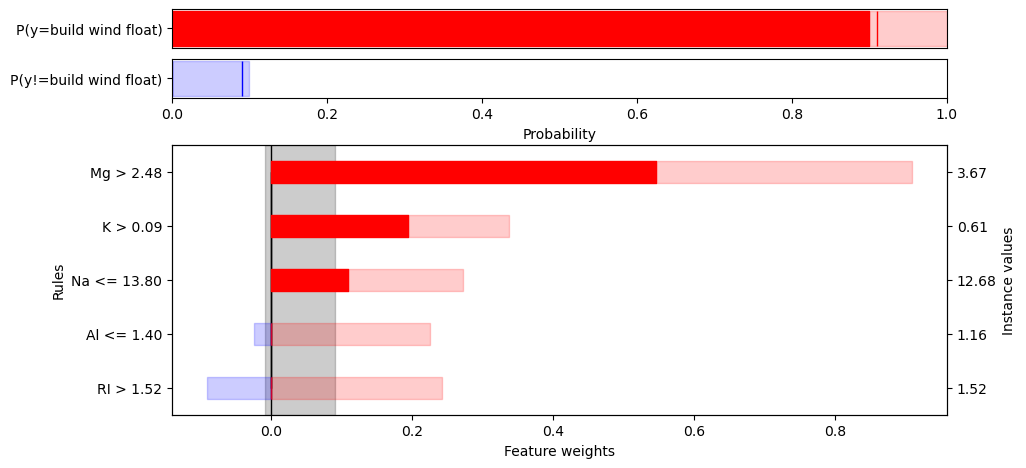

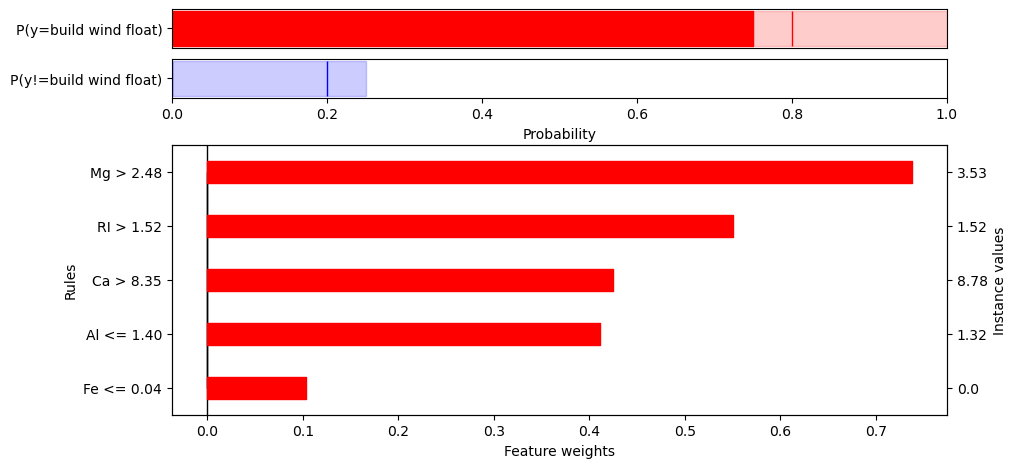

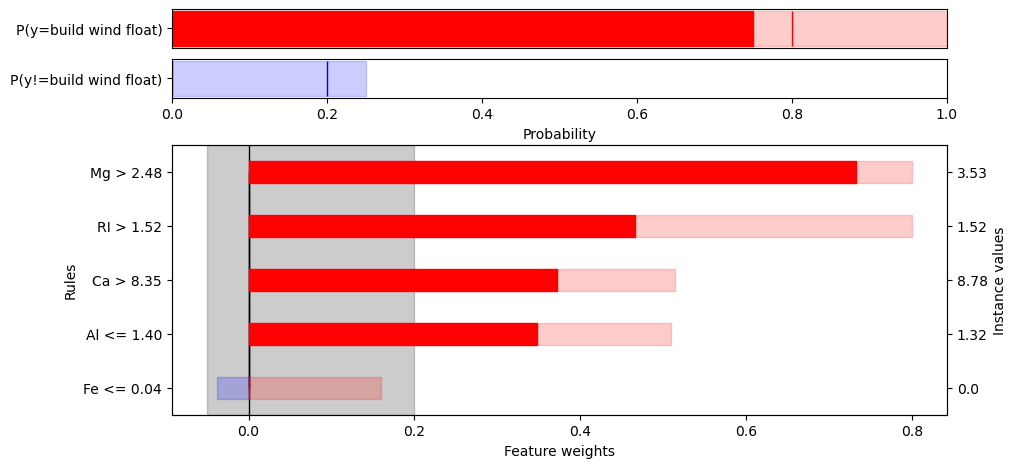

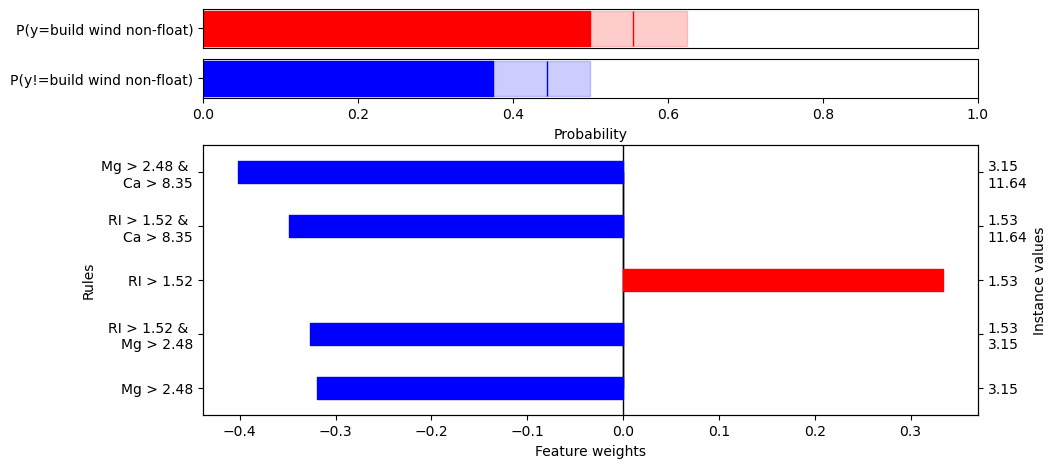

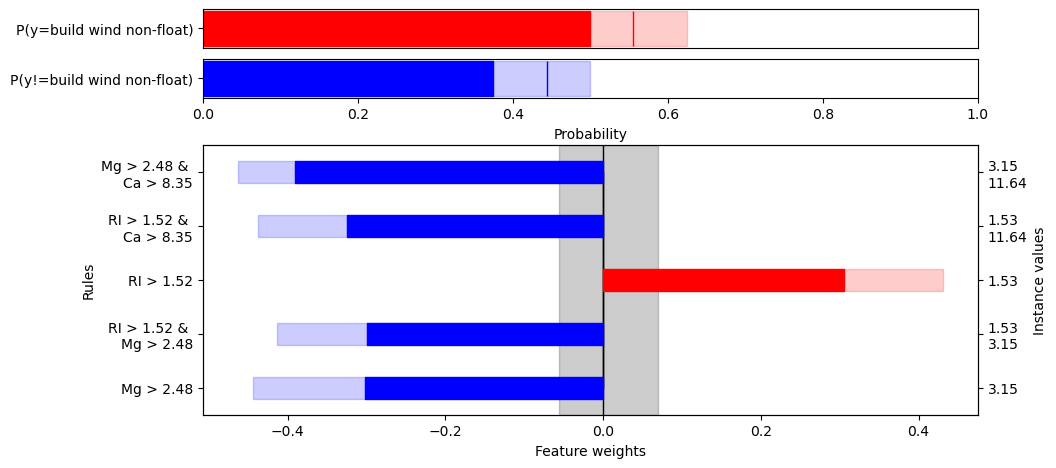

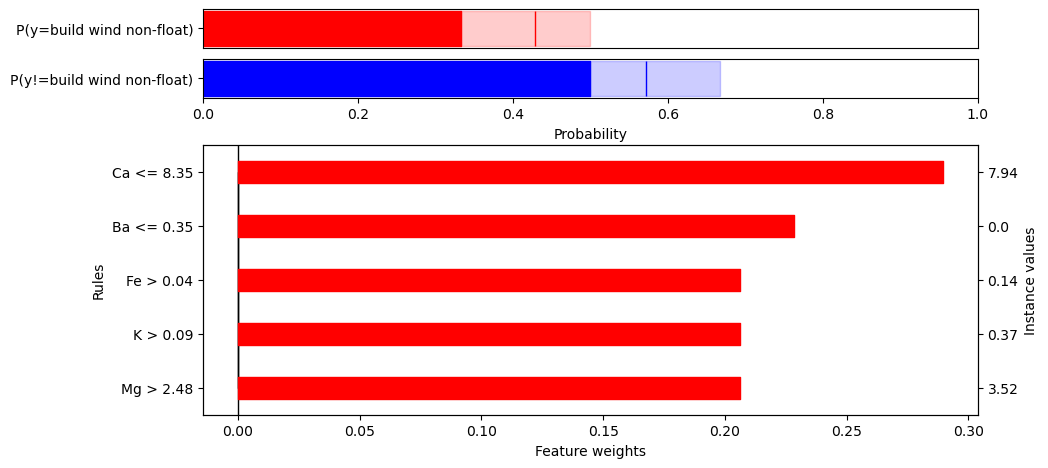

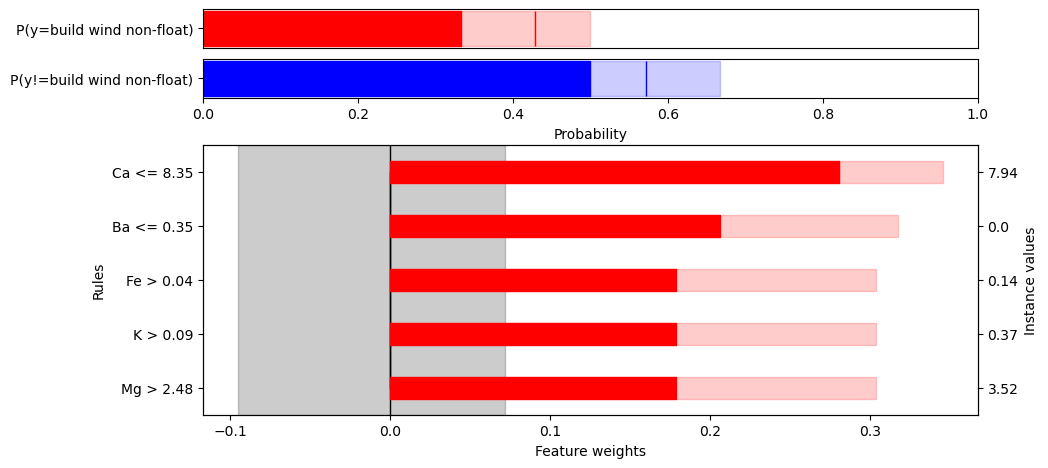

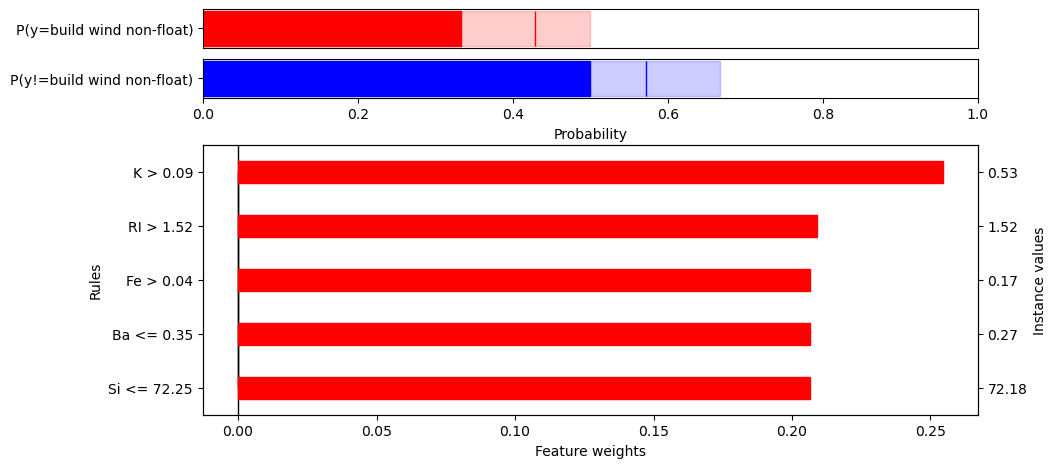

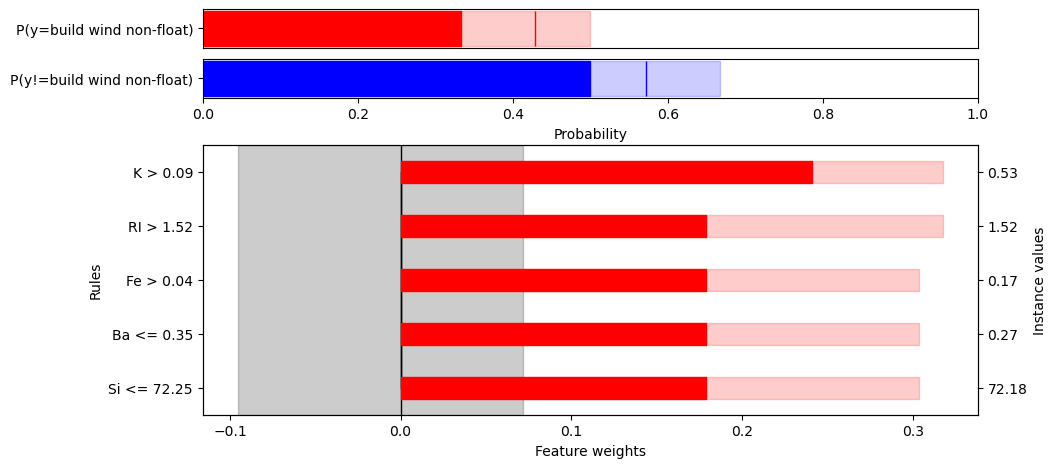

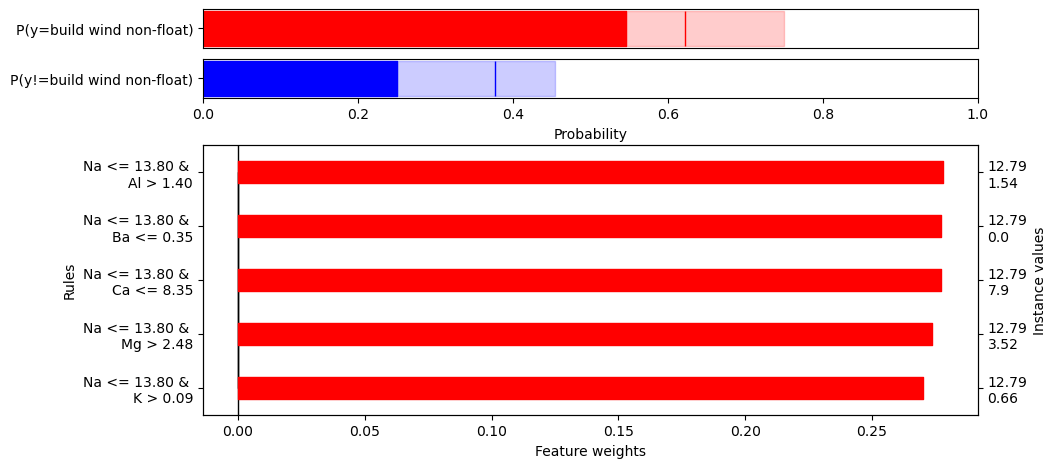

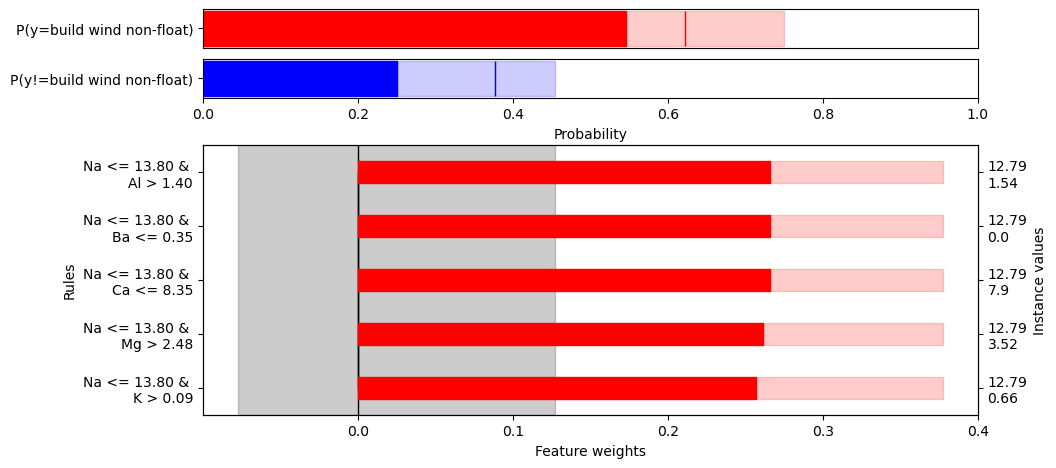

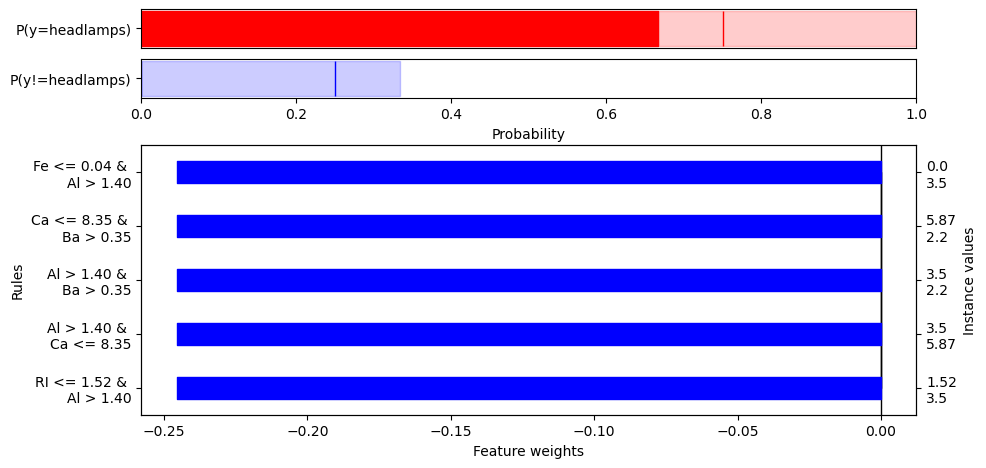

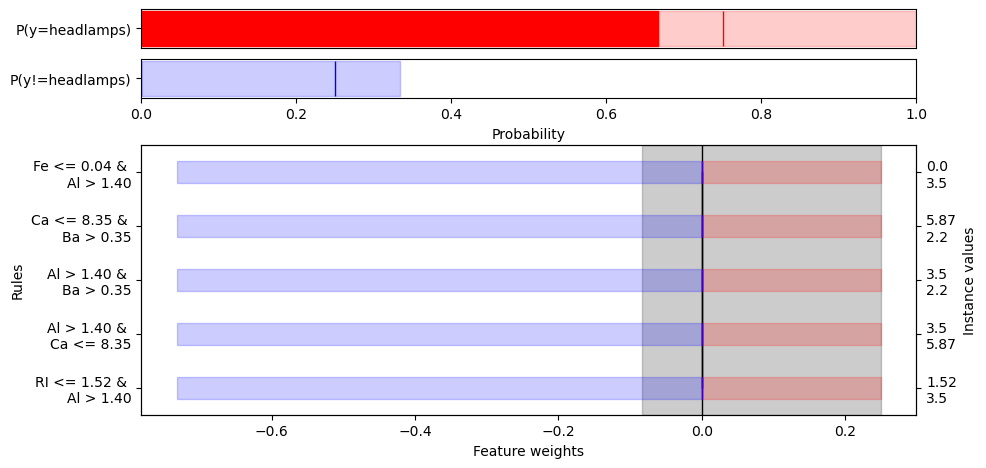

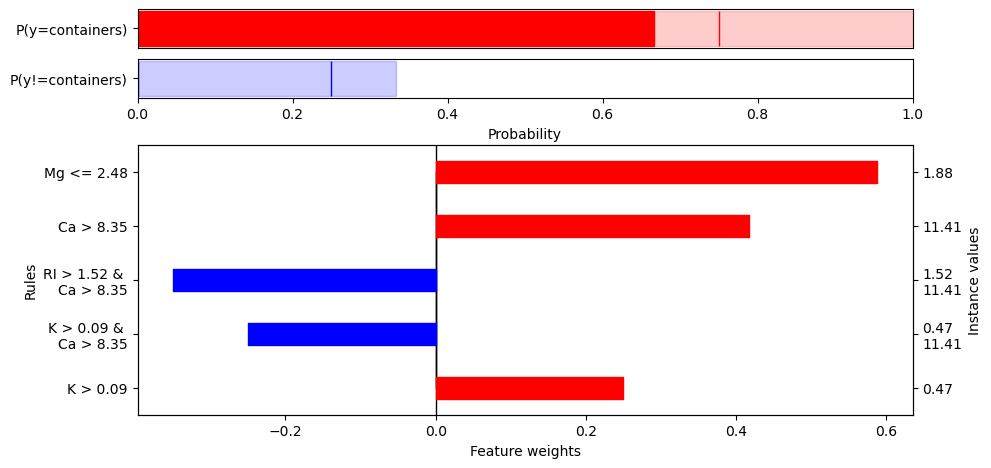

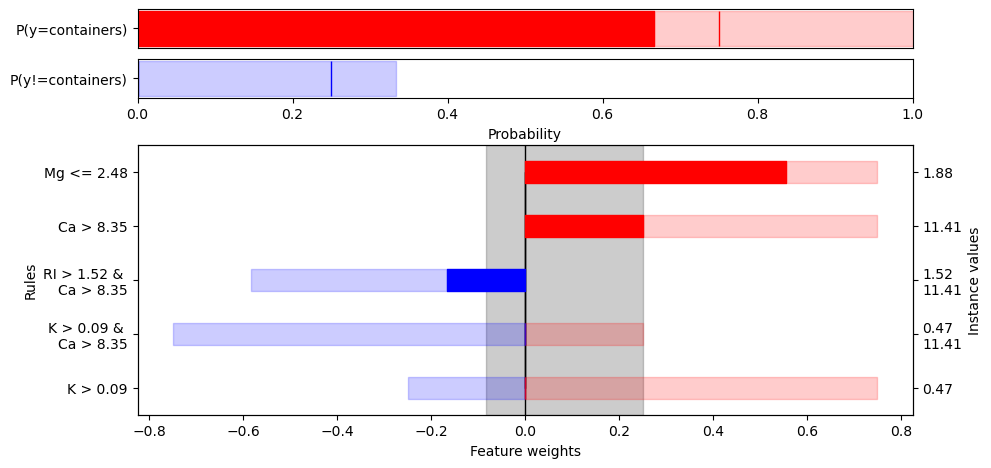

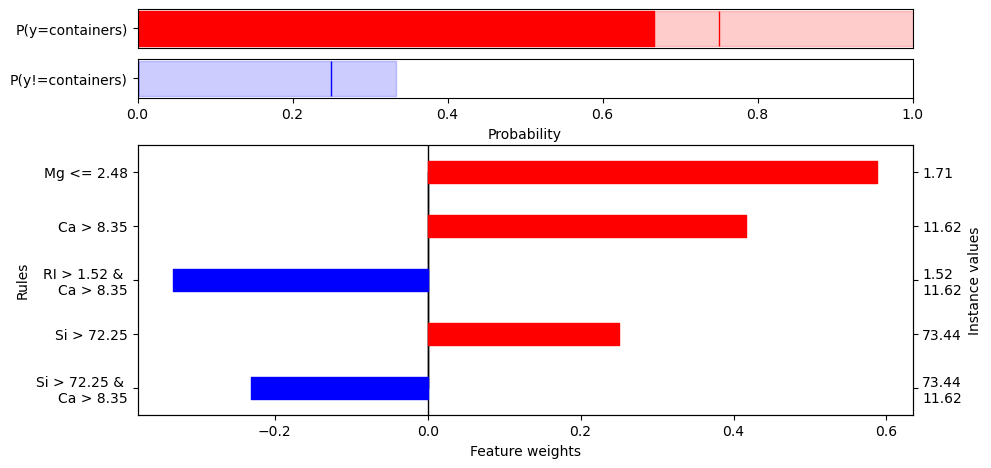

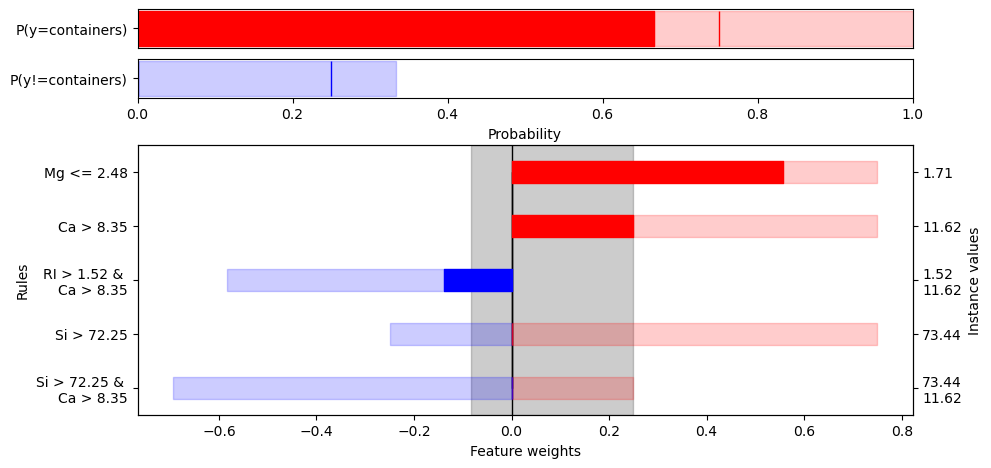

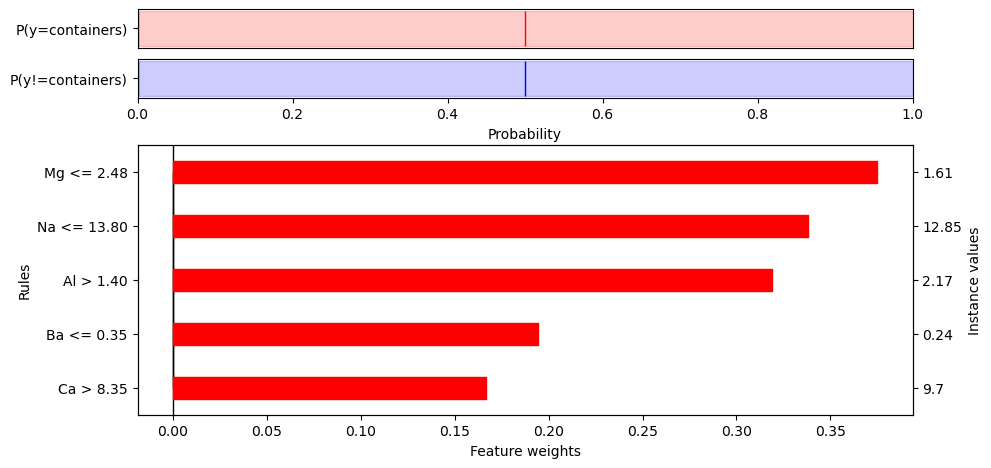

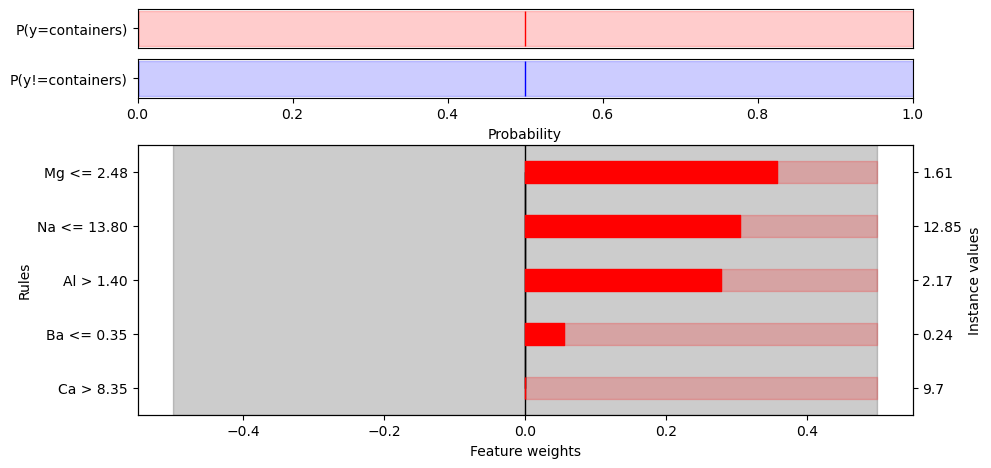

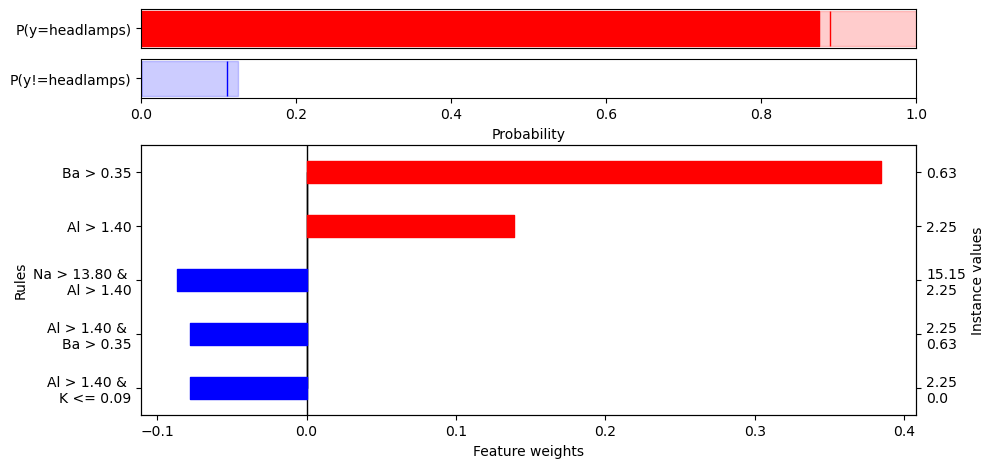

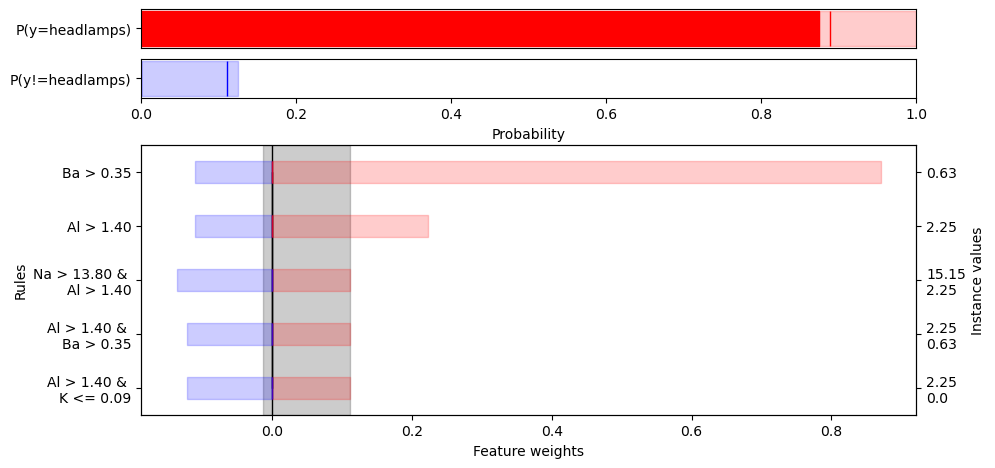

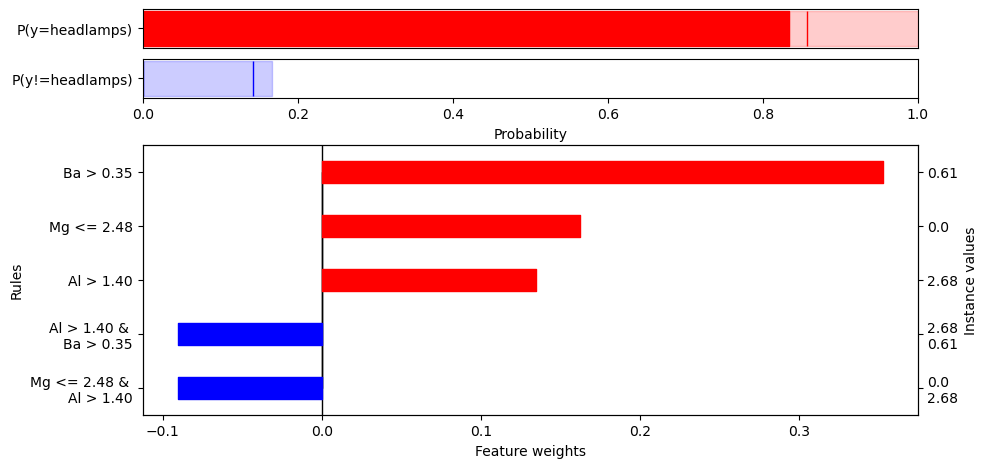

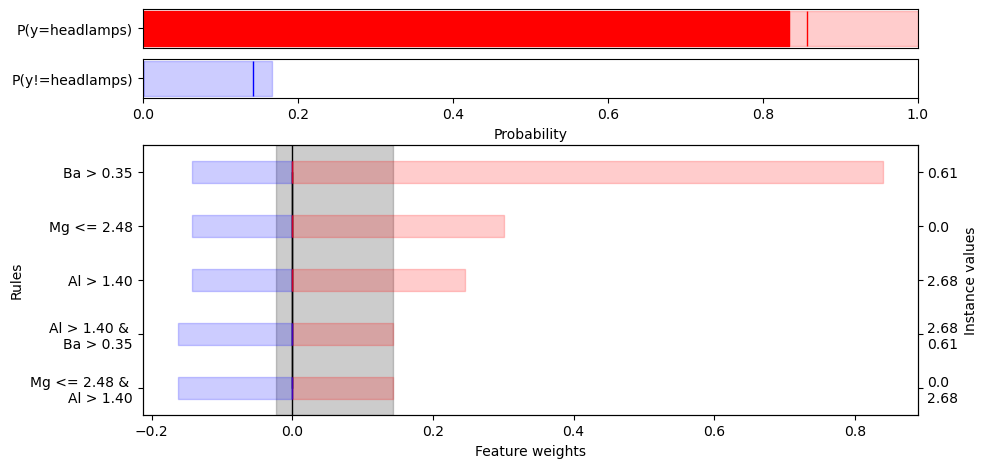

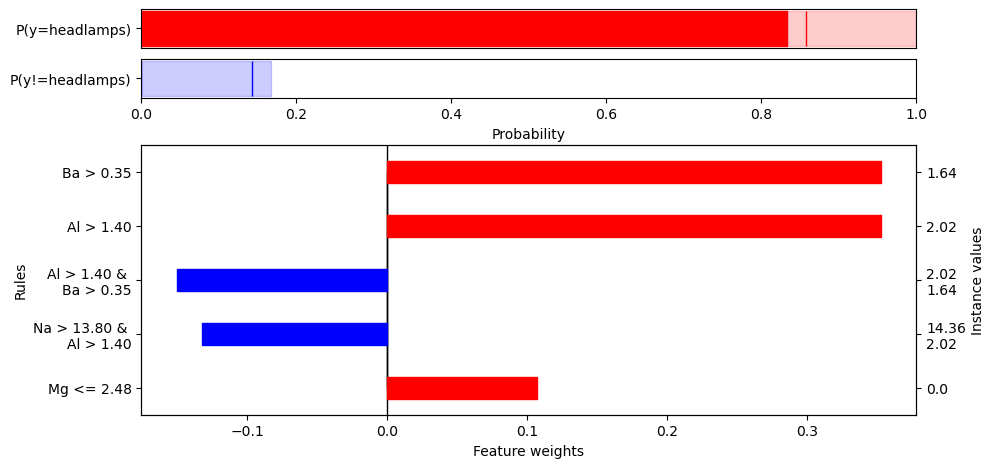

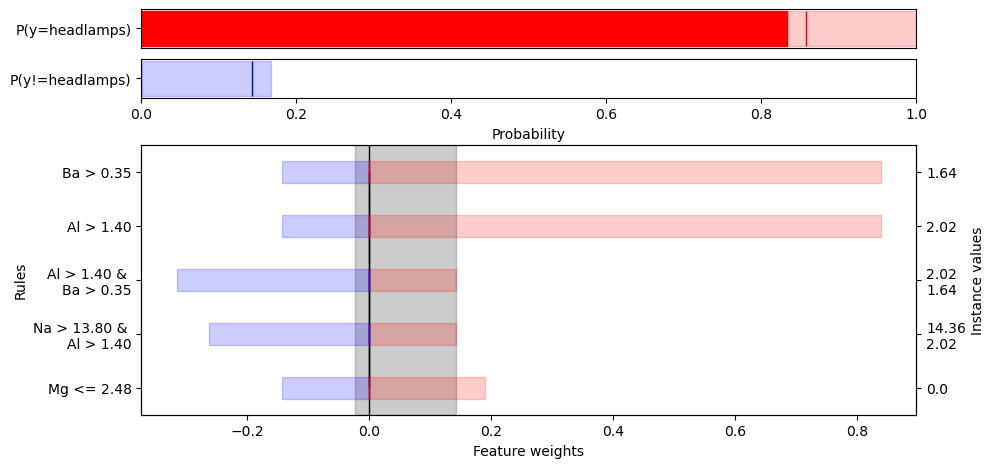

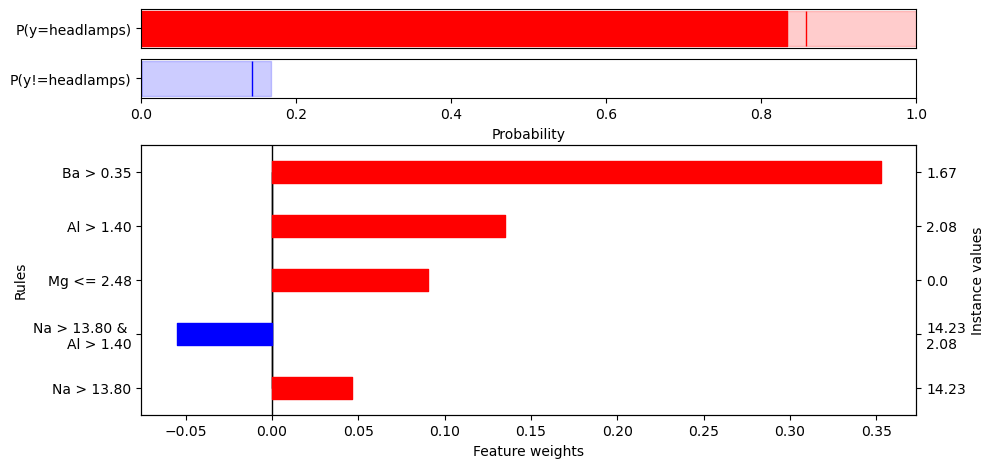

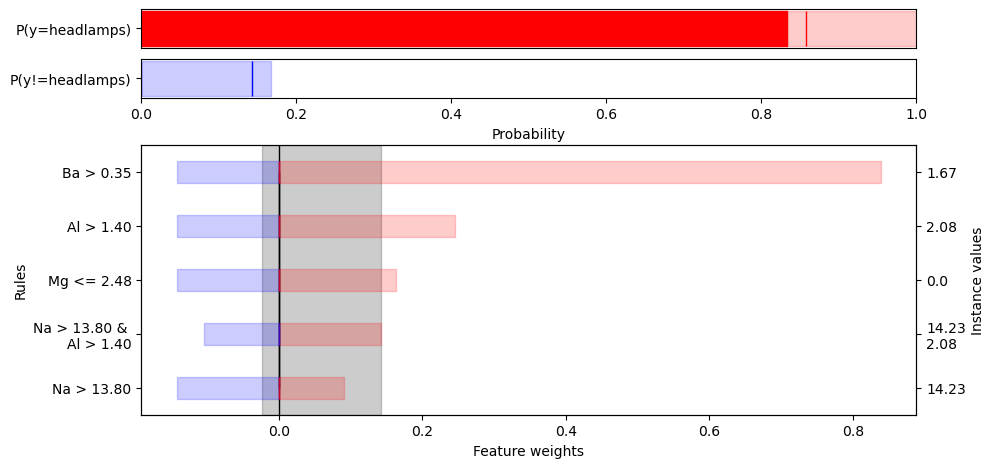

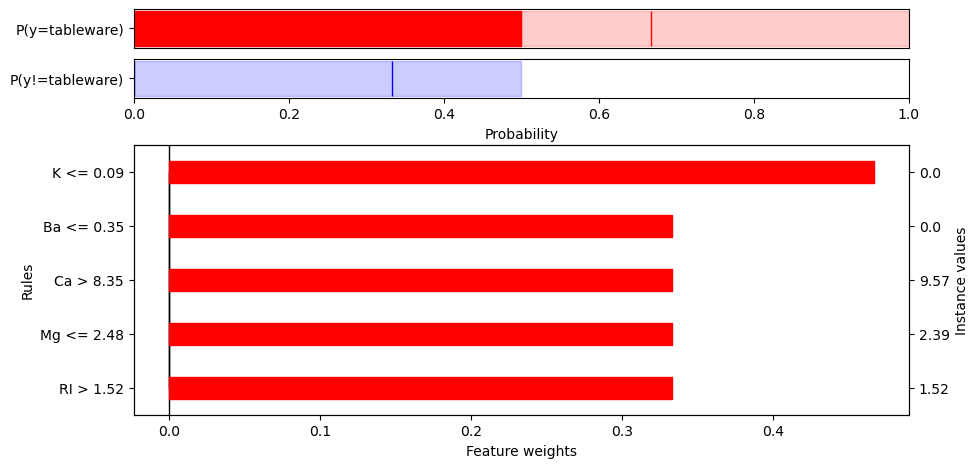

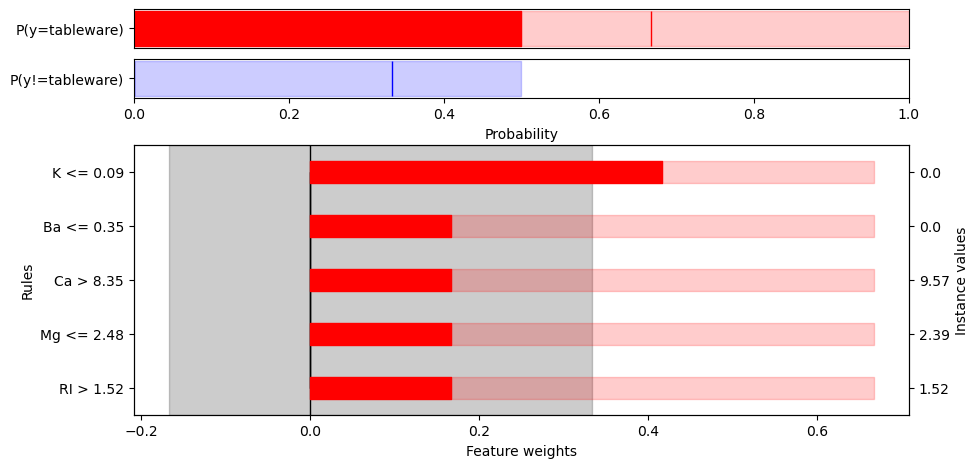

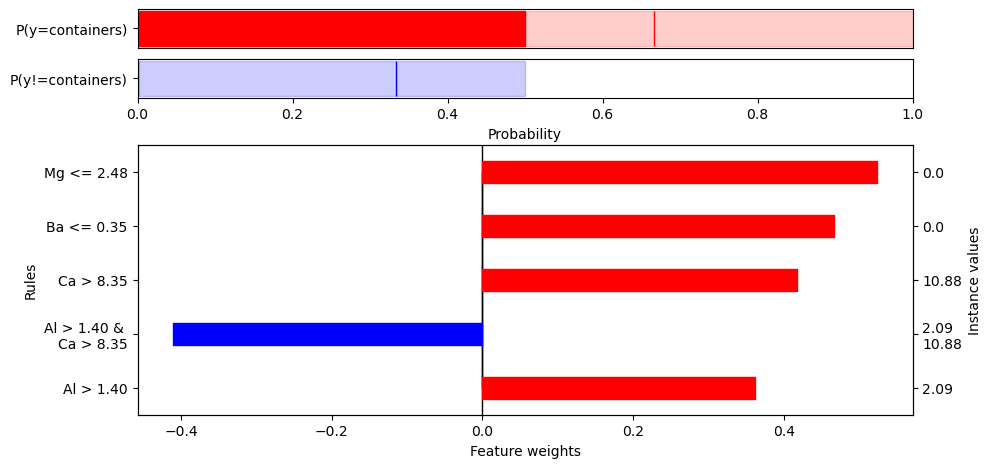

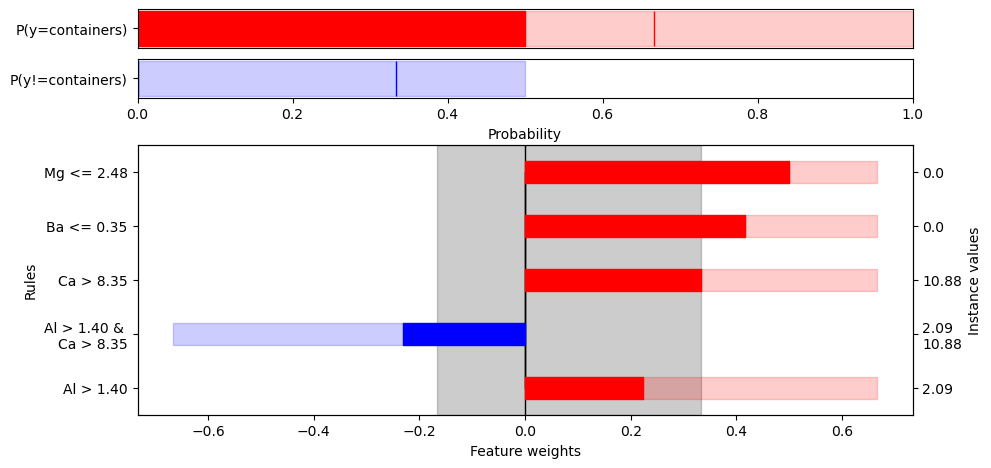

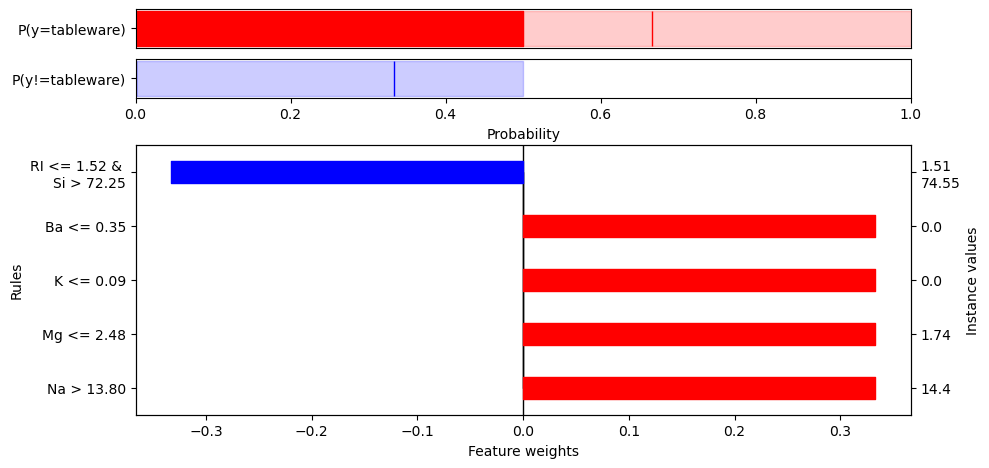

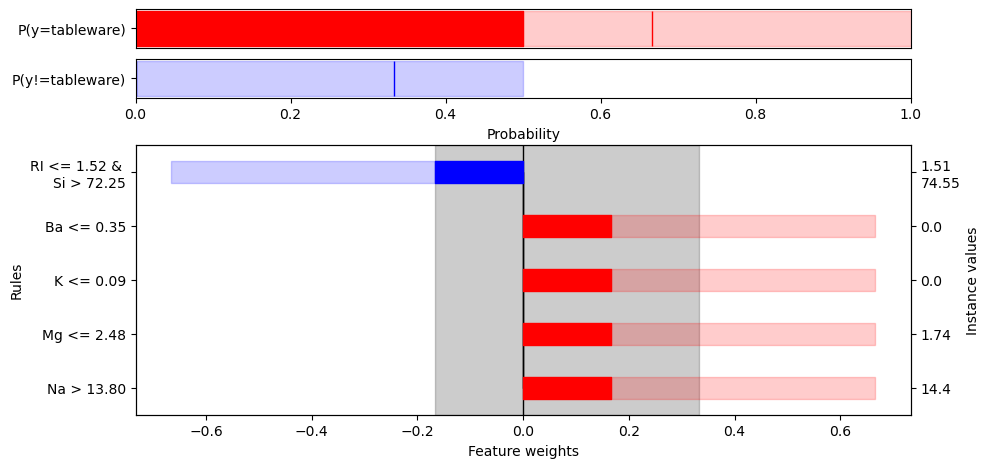

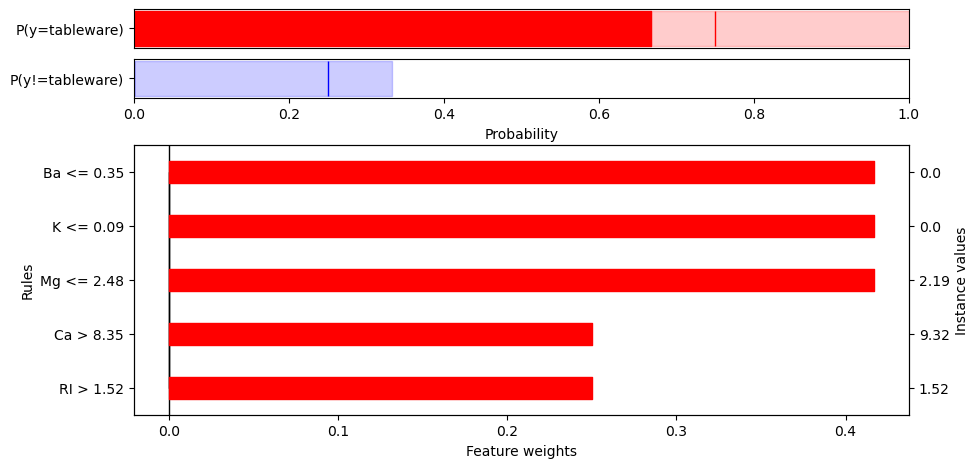

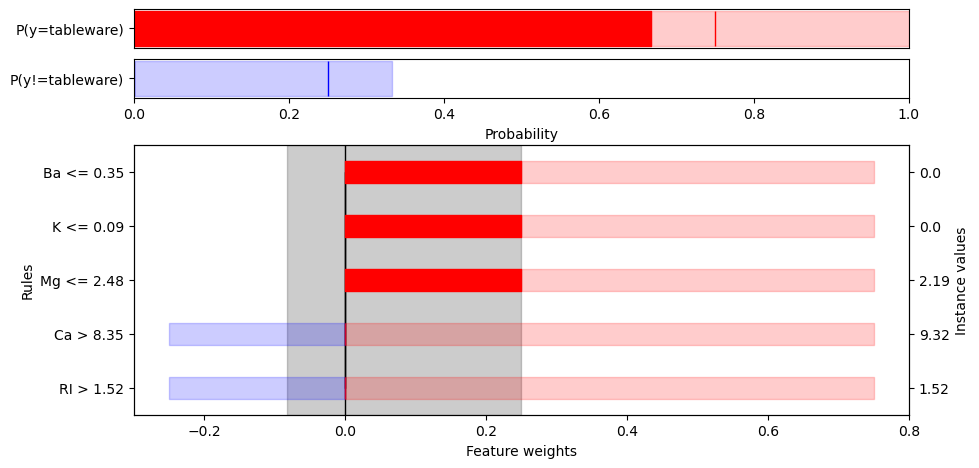

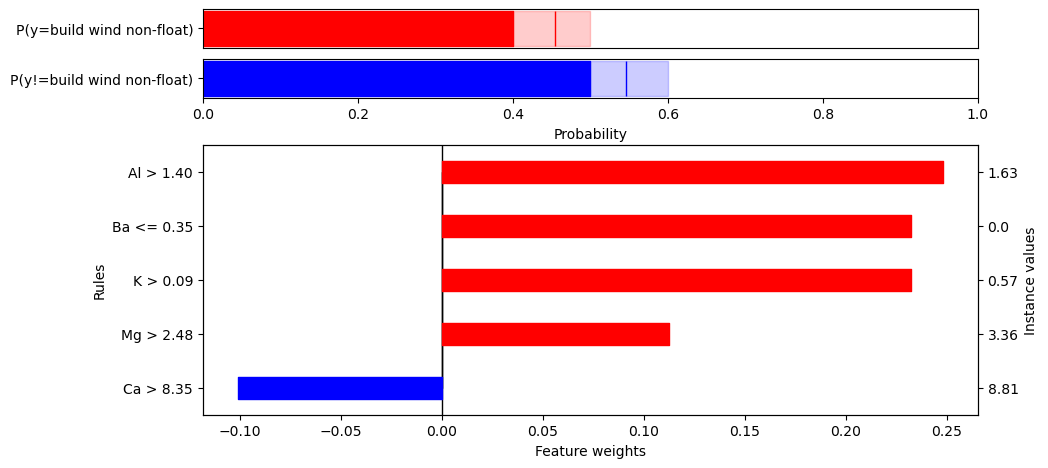

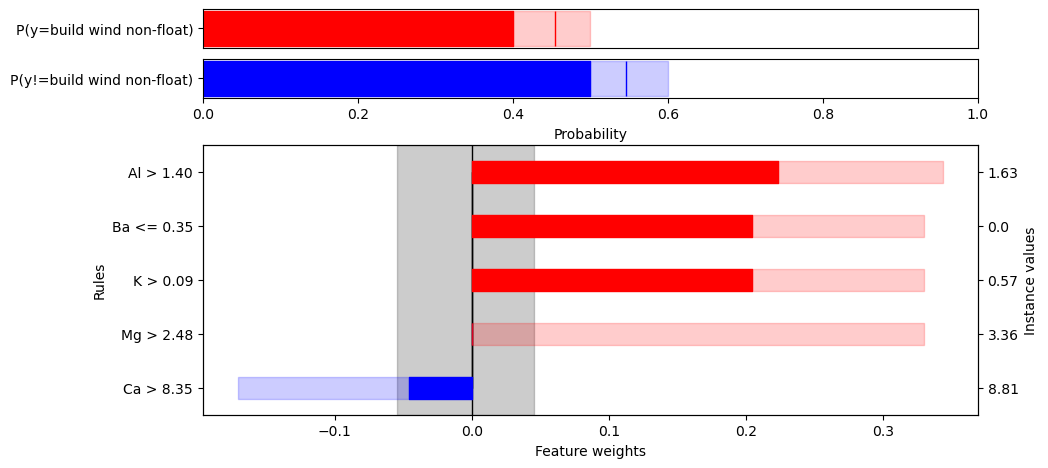

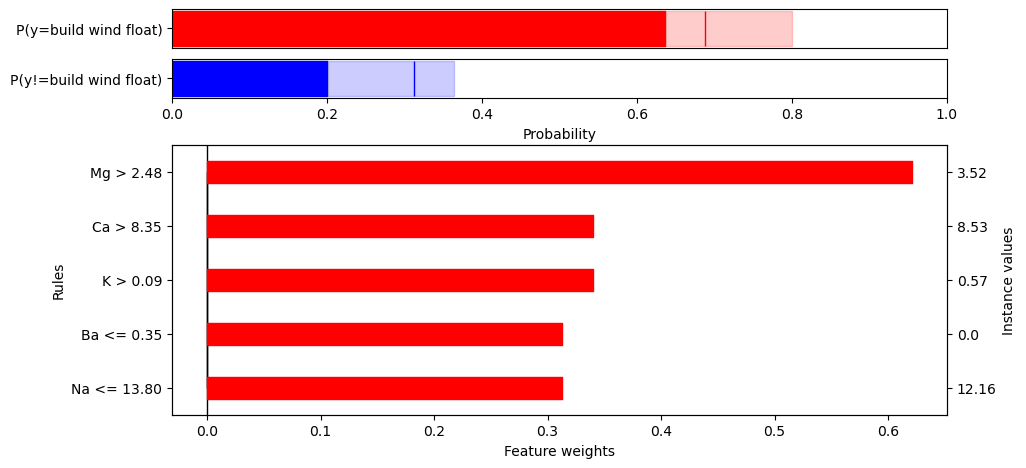

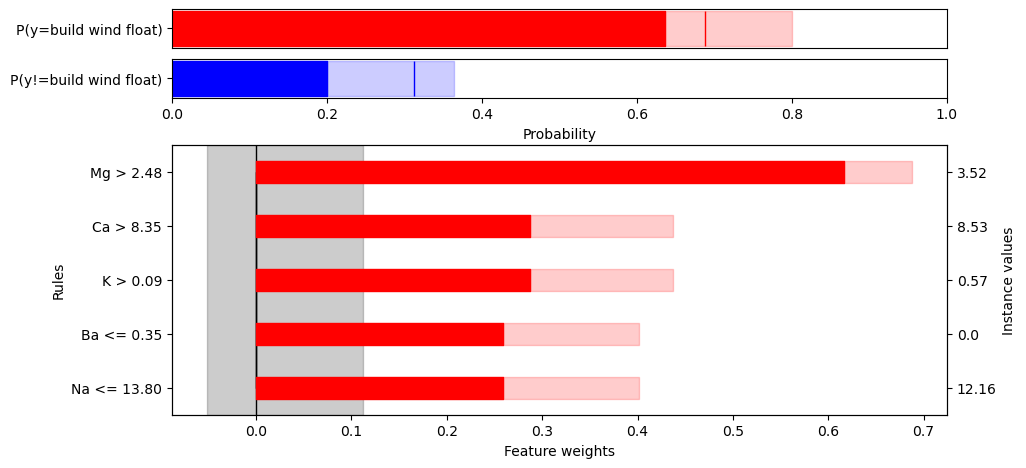

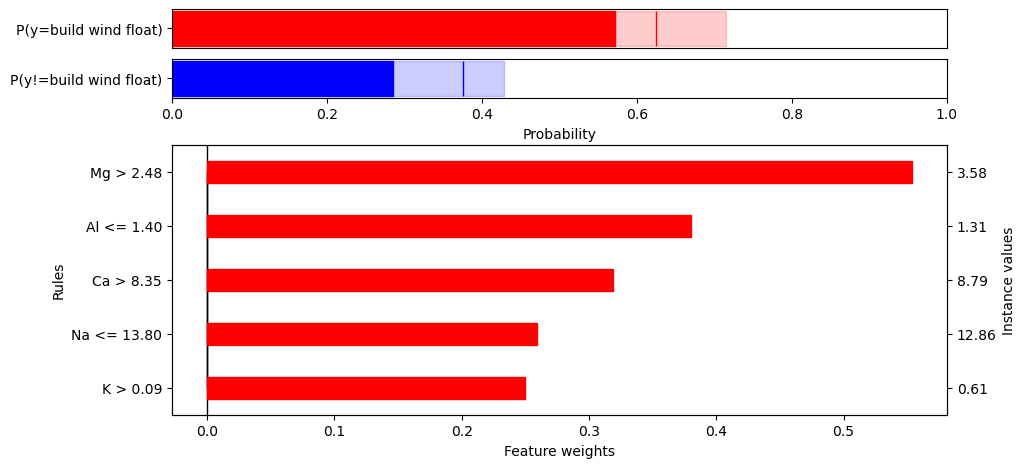

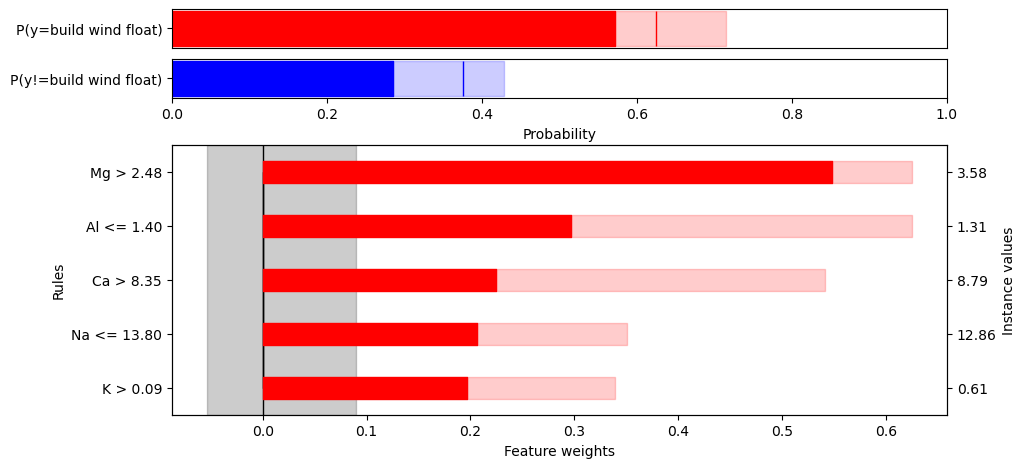

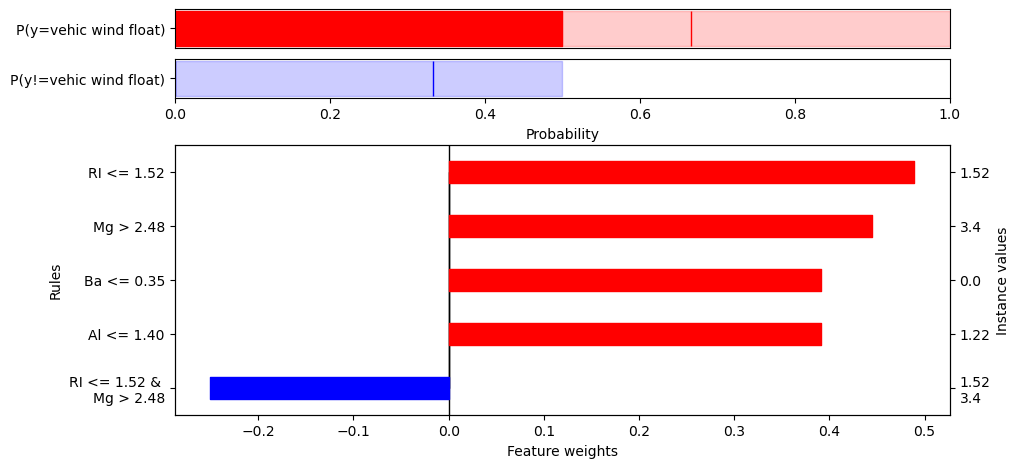

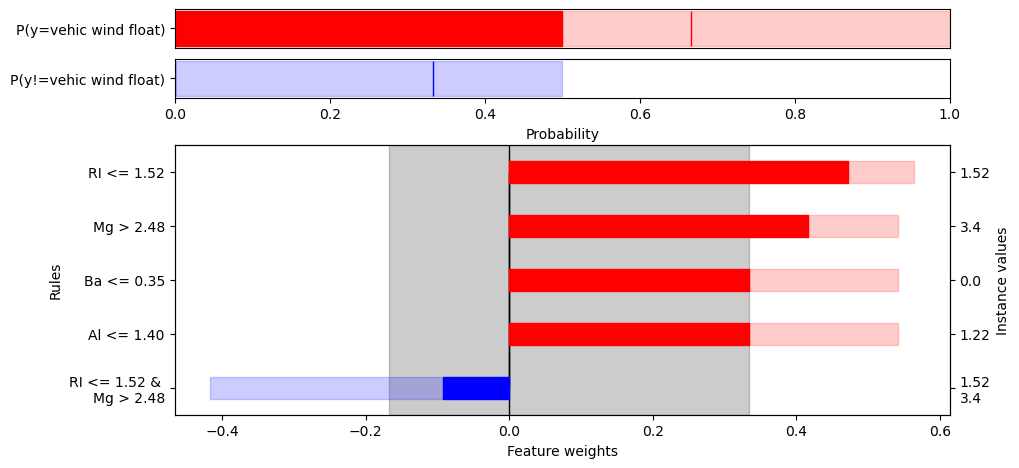

In [31]:
factual_explanations.add_conjunctions()
for i in range(num_to_test):
    explanation = factual_explanations.get_explanation(i)
    explanation.plot_explanation(n_features_to_show=5, filename=f'{dataSet}_{i}_c{testY[i]}_p{predicted_classes[i]}_conjunctive_factual.png')
    explanation.plot_explanation(uncertainty=True, n_features_to_show=5, filename=f'{dataSet}_{i}_c{testY[i]}_p{predicted_classes[i]}_conjunctive_factual_uncertainty.png')

In [32]:
counterfactual_explanations = ce.explain_counterfactual(testX)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:1557: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5))


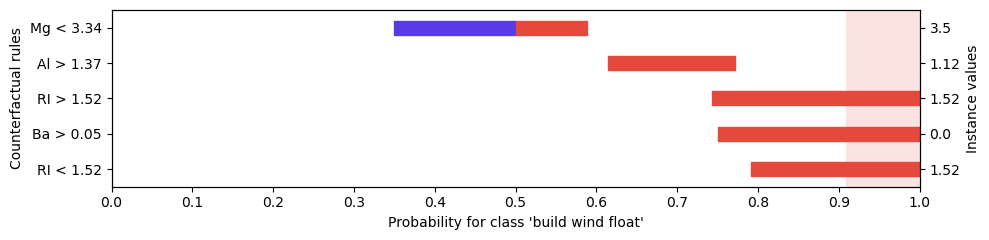

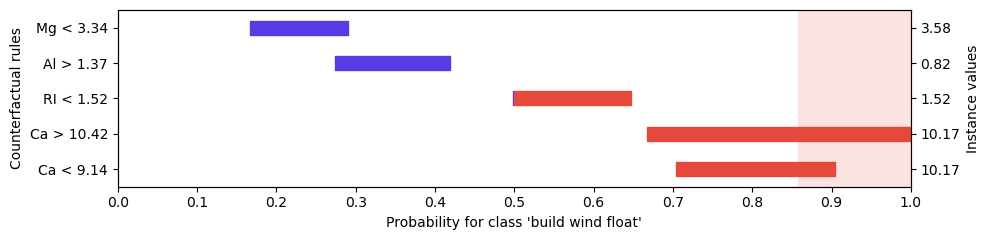

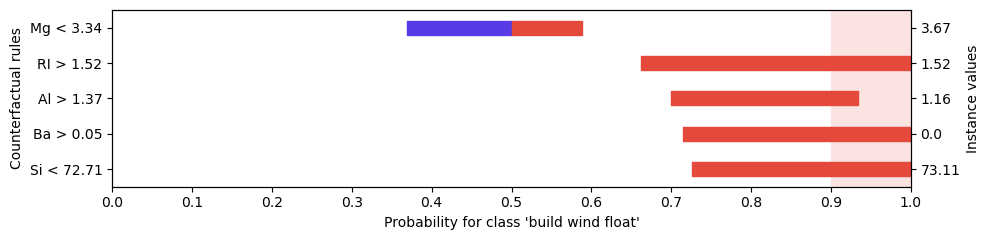

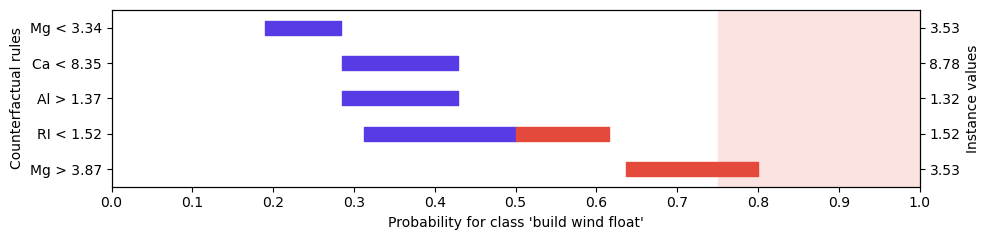

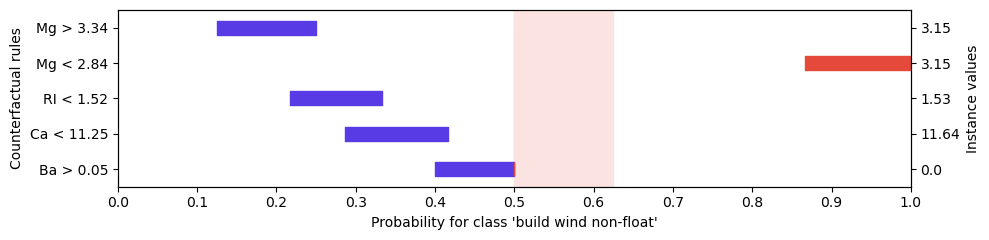

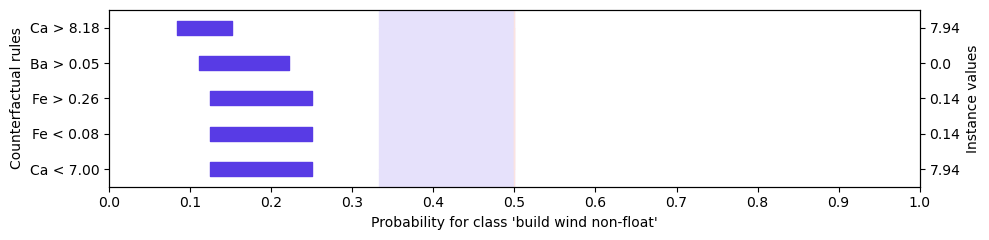

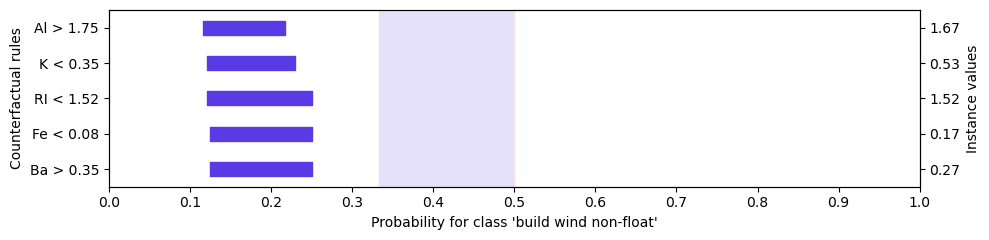

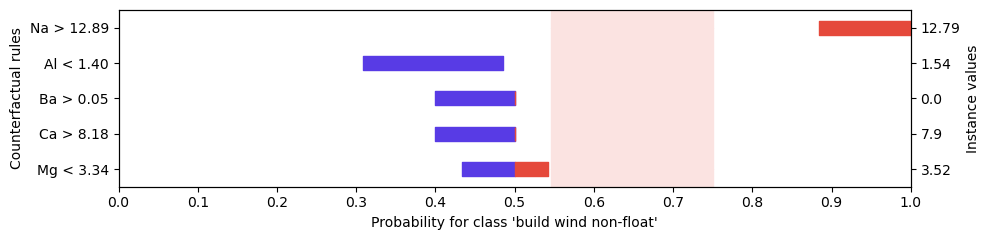

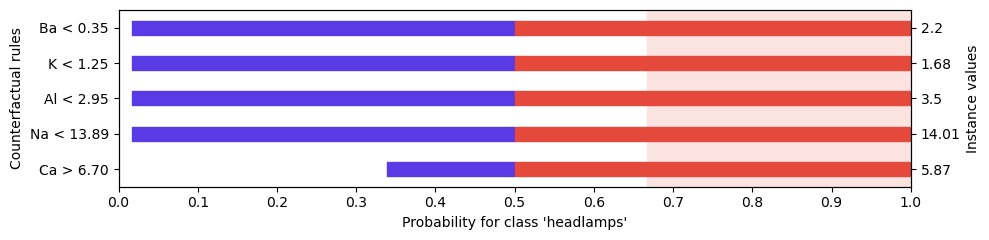

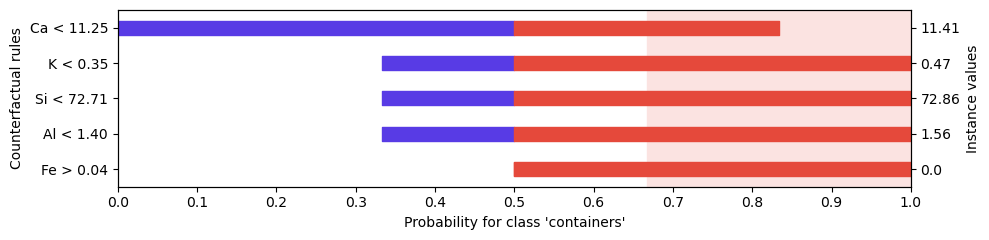

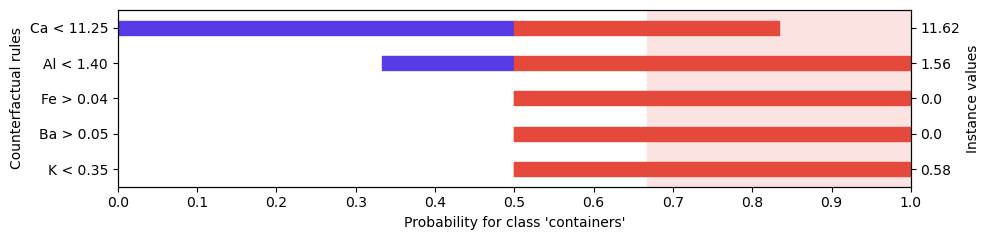

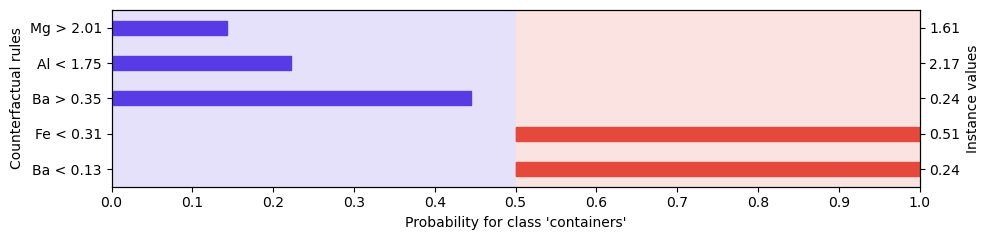

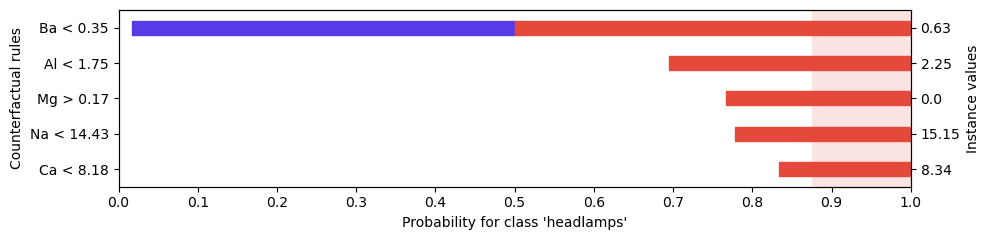

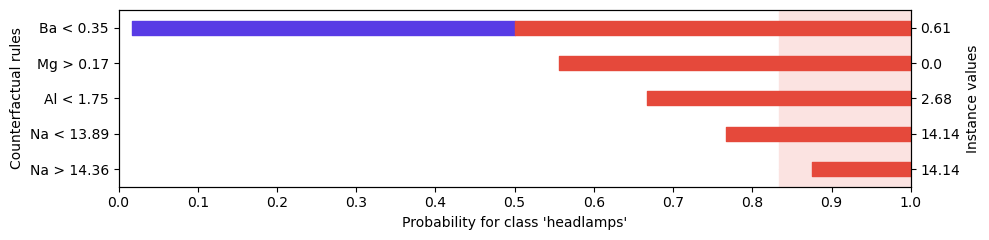

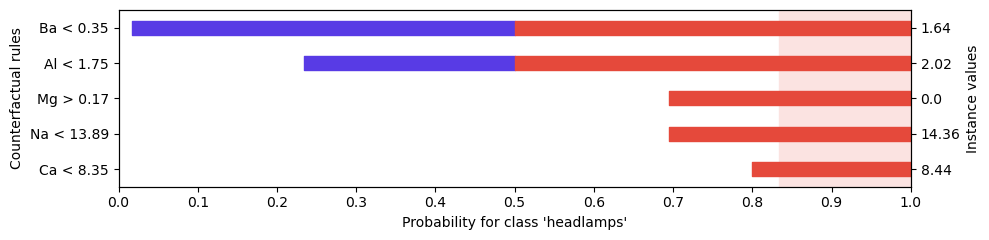

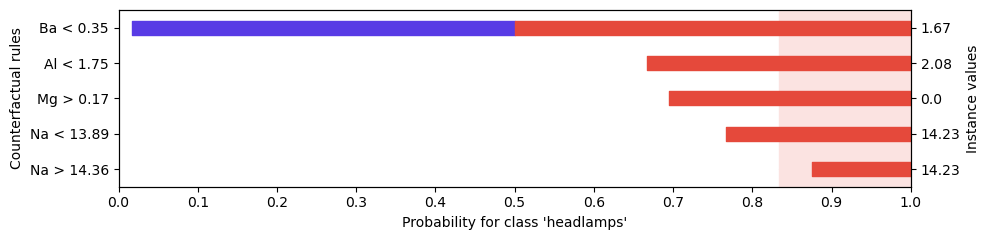

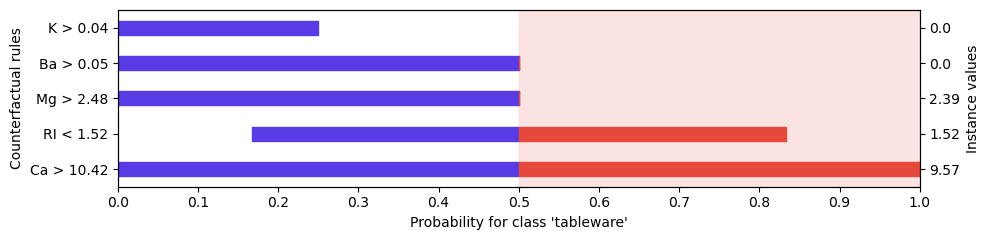

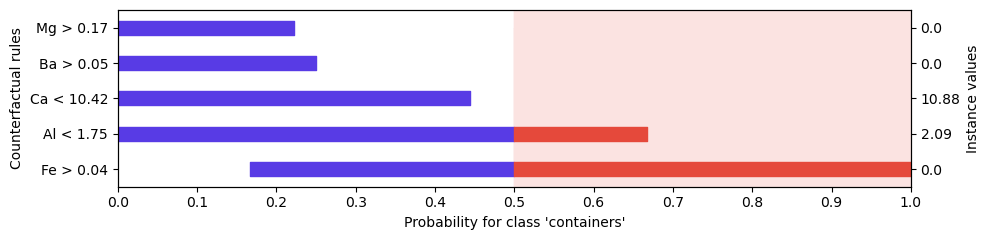

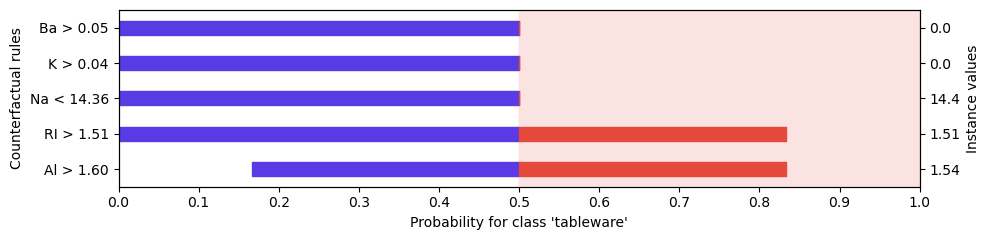

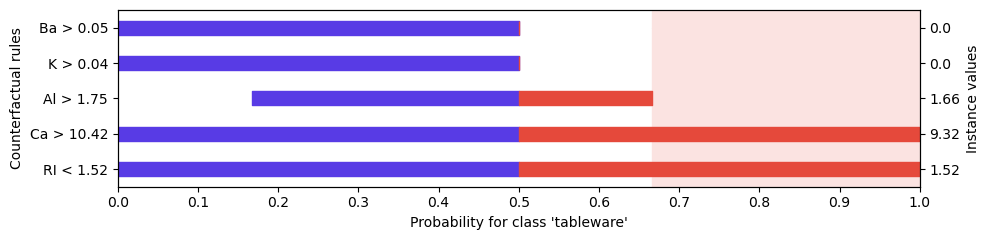

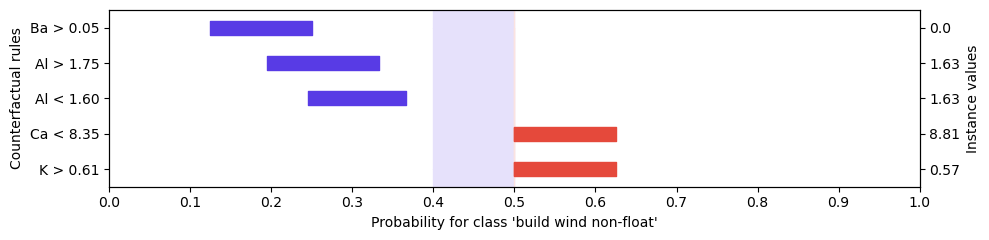

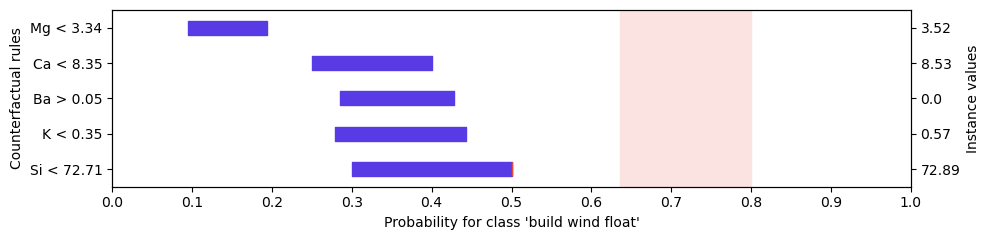

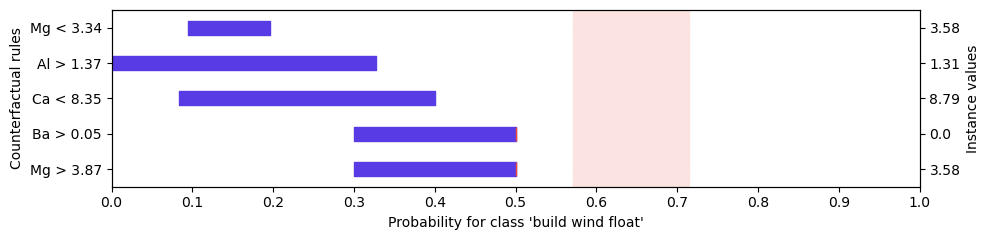

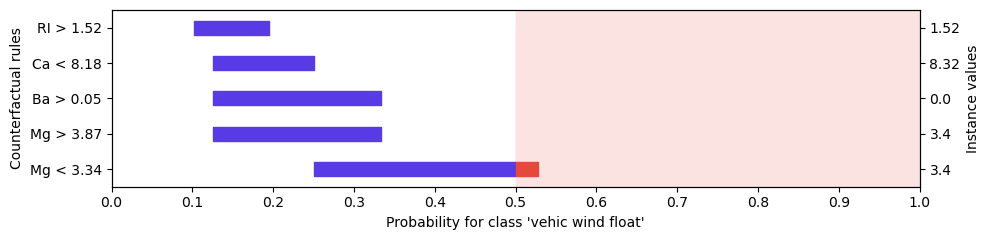

In [33]:
for i in range(num_to_test):
    explanation = counterfactual_explanations.get_explanation(i)
    explanation.plot_explanation(n_features_to_show=5, filename=f'{dataSet}_{i}_c{testY[i]}_p{predicted_classes[i]}_simple_counterfactual.png')

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:1557: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5))


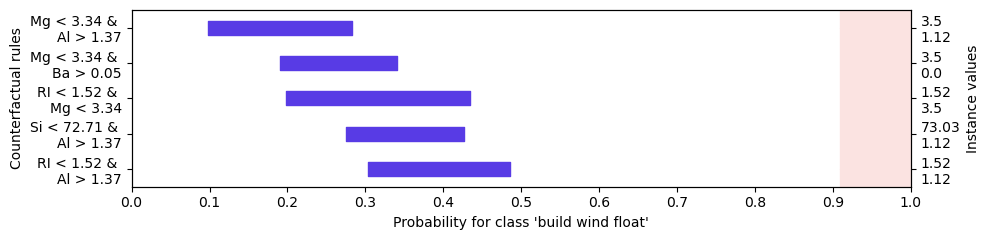

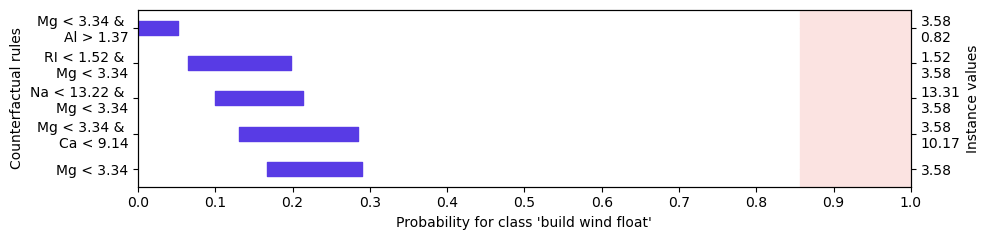

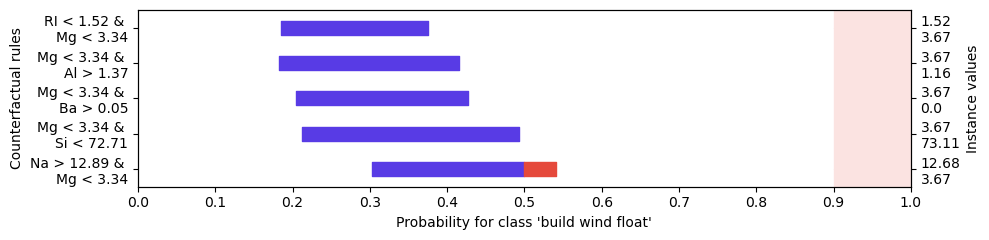

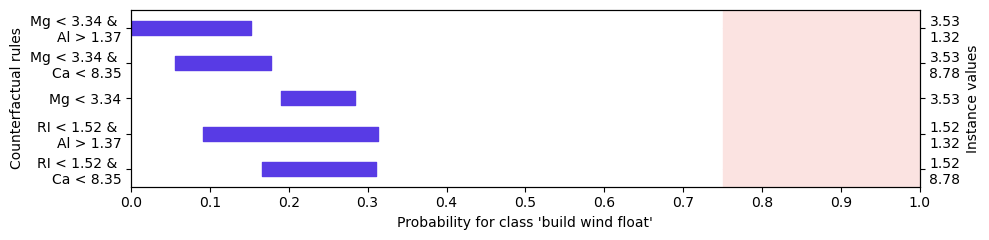

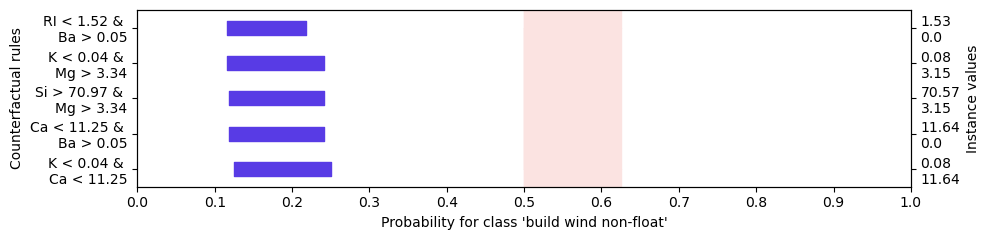

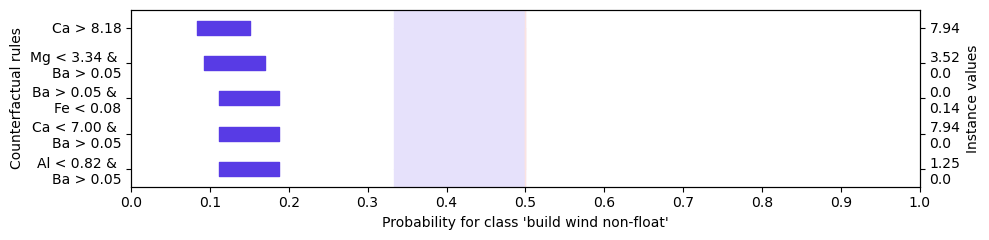

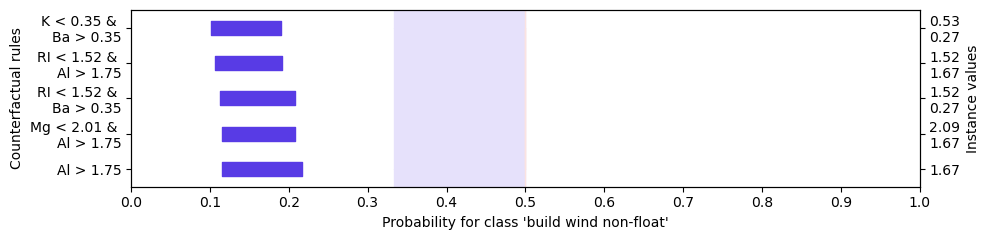

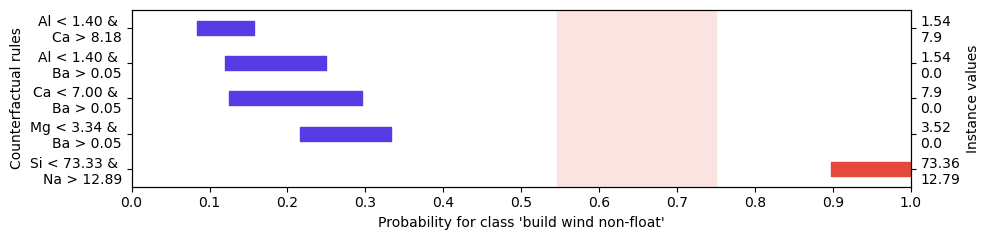

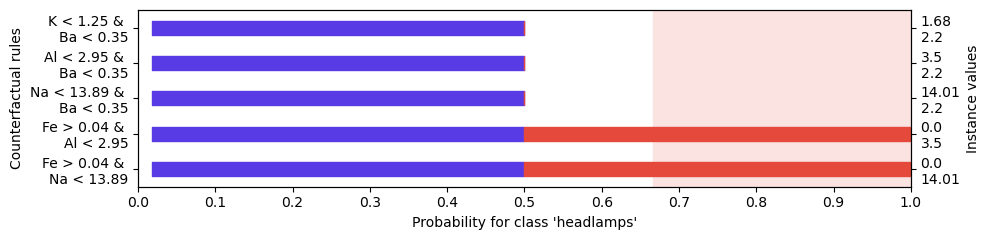

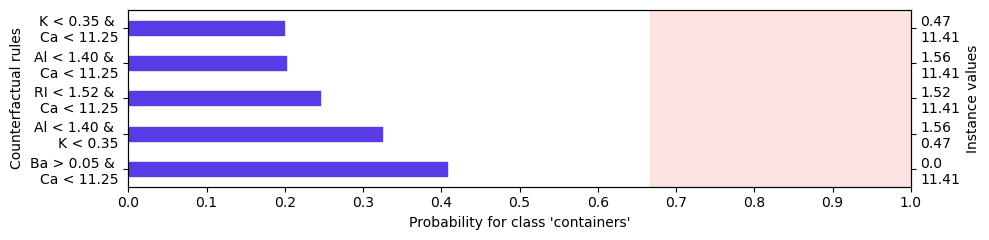

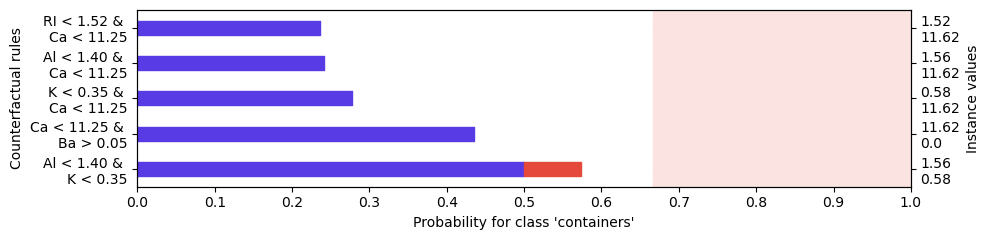

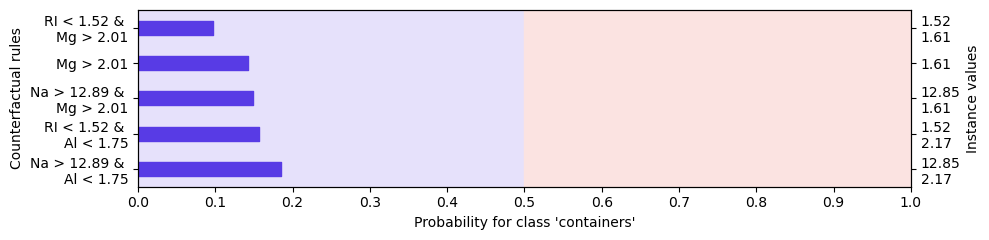

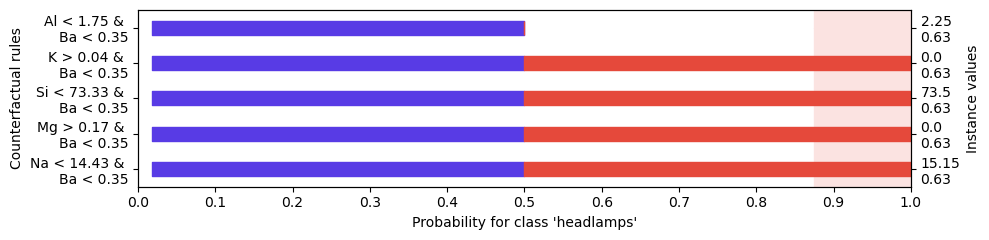

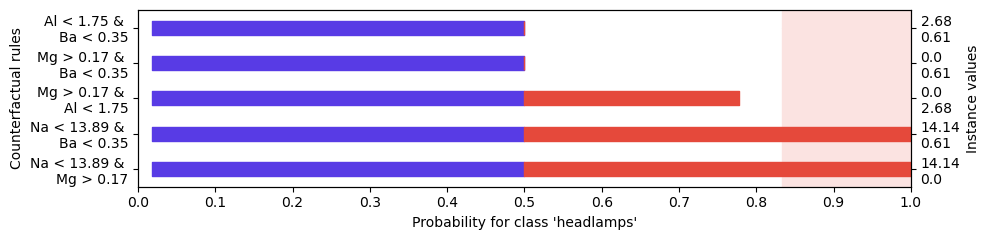

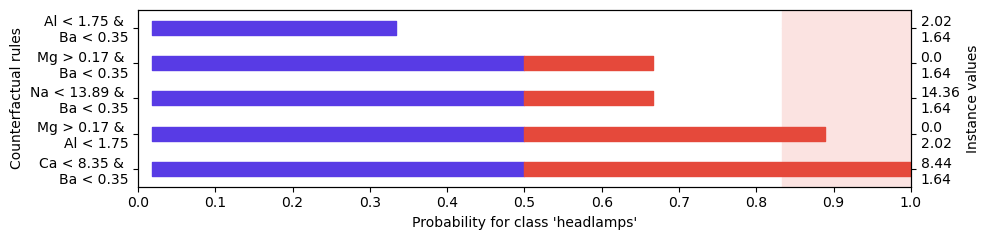

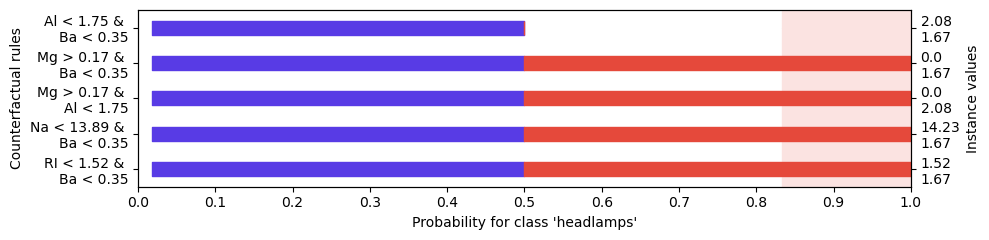

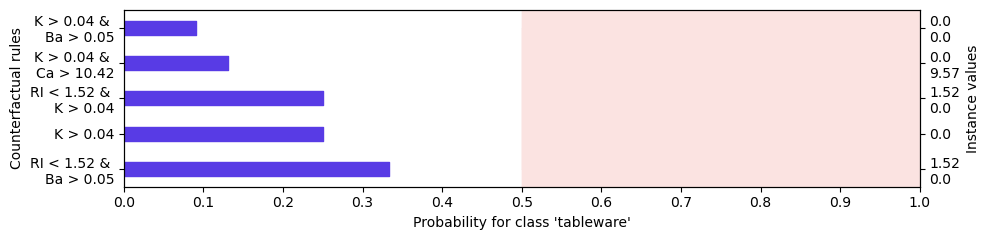

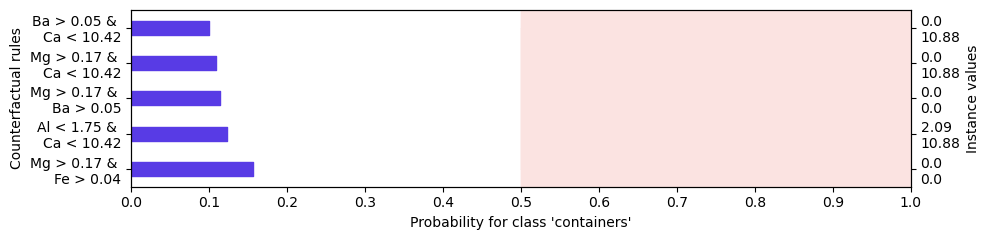

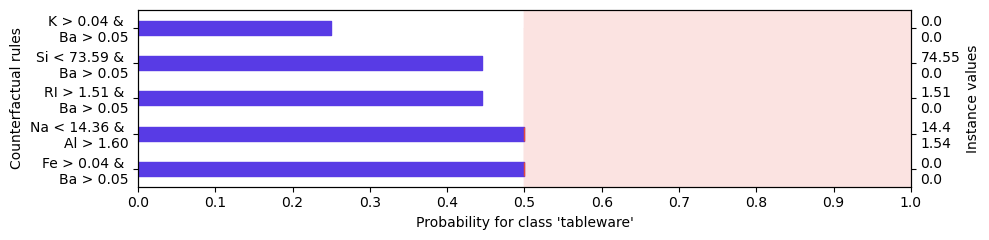

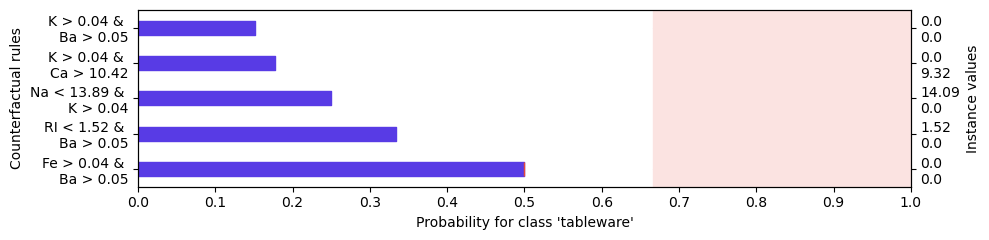

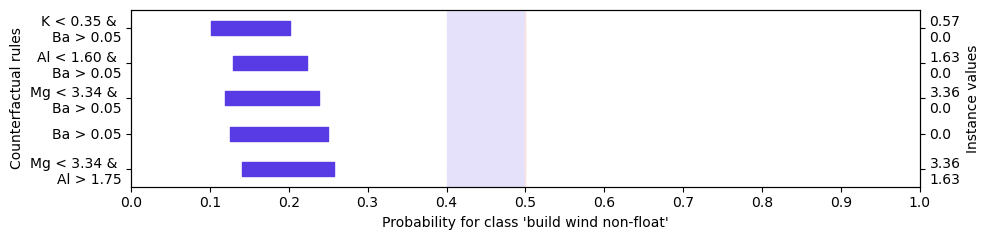

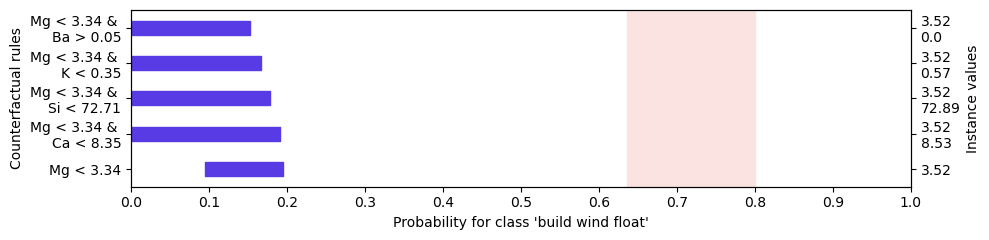

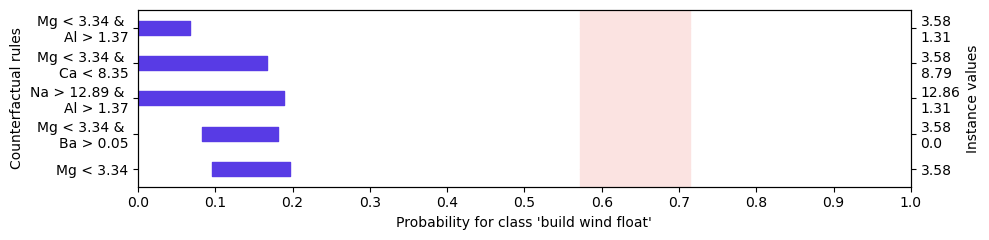

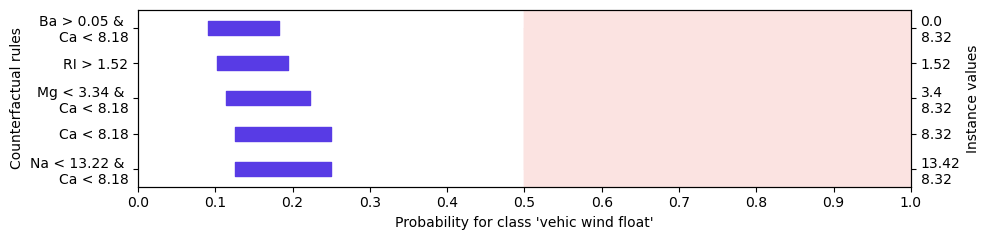

In [34]:
counterfactual_explanations.add_conjunctions()
for i in range(num_to_test):
    explanation = counterfactual_explanations.get_explanation(i)
    explanation.plot_explanation(n_features_to_show=5, filename=f'{dataSet}_{i}_c{testY[i]}_p{predicted_classes[i]}_conjunctive_counterfactual.png')